# Analysis of Basic RAG Pipeline with GPT-3.5-Turbo

**Database**: Max Tokens 120, Sentence Chunking, Overlap 20

**Instructions**: "You are a glycobiology assistant for GlyGen that helps scientists navigate and utilize a bioinformatics knowledgebase."

**Prompt Template**: 

"Context information from 'Essentials of Glycobiology' (4th edition) is below.\n" \
"---------------------\n" \
"{context_str}\n" \
"---------------------\n" \
"Given the information from the selected text and not prior knowledge, " \
"answer the query.\n" \
"Query: {query_str}\n" \
"Answer: "

**Retrieval**: Top-K = 5, Response Mode = "tree-summarize"

**LLM, Embedding Model**: GPT-3.5-Turbo for both

**Dummy Comparison Constraints**: RAG with GPT-4o Glycobiology Definition

### About the RAGAS Metrics:

**Faithfulness** -> measures the factual consistency of the generated answer against the given context. It is calculated from answer and retrieved context. The answer is scaled to (0,1) range. Higher the better.

**Answer Relevance** -> focuses on assessing how pertinent the generated answer is to the given prompt. A lower score is assigned to answers that are incomplete or contain redundant information and higher scores indicate better relevancy. This metric is computed using the question, the context and the answer.

**Answer Semantic Similarity** -> semantic resemblance between the generated answer and the ground truth. This evaluation is based on the ground truth and the answer, with values falling within the range of 0 to 1. A higher score signifies a better alignment between the generated answer and the ground truth.

**Context Relevance** *RECENTLY DEPRECATED* -> gauges the ratio of question-relevant sentences in the contexts to estimate the amount of essential information in the retrieved contexts. To compute this, we initially estimate the value of |*S*| by identifying sentences within the retrieved context that are relevant for answering the given question. The values fall within the range of (0, 1), with higher values indicating better relevancy.

**Context Precision** -> evaluates whether all of the ground-truth relevant items present in the contexts are ranked higher or not. Ideally all the relevant chunks must appear at the top ranks. This metric is computed using the question, ground_truth and the contexts, with values ranging between 0 and 1, where higher scores indicate better precision.

**Context Recall** -> extent to which the retrieved context aligns with the annotated answer, treated as the ground truth. It is computed based on the ground truth and the retrieved context, and the values range between 0 and 1, with higher values indicating better performance.

In [60]:
import pandas as pd
from scipy.stats import ttest_ind
import matplotlib.pyplot as plt
import seaborn as sns
from nltk import word_tokenize, PunktSentenceTokenizer
from nltk.translate.bleu_score import sentence_bleu
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from scipy.stats import pearsonr, spearmanr

### Helper Functions

In [61]:
# helper function for preprocessing contexts
def extract_context_list(sample):
    """converts the contexts column into a list of strings"""
    sample = sample.replace('[', '')
    sample = sample.replace(']', '')
    sample = sample.split('\n')
    for i, t in enumerate(sample):
        sample[i] = t[1:-1]
        if sample[i][0] == "'":
            sample[i] = sample[i][1:]

    return sample

# helper function to compute sentence recall
def sent_recall(target: str, contexts: list):
    """Computes sentence recall between target and contexts"""
    sentence_tokenizer = PunktSentenceTokenizer()
    target_sentences = sentence_tokenizer.tokenize(target)
    context_sentences = []
    for context in contexts:
        context_sentences.extend(sentence_tokenizer.tokenize(context))
    hits = [True for sentence in target_sentences if sentence in context_sentences]
    return len(hits) / len(context_sentences)

# helper function to compute sentence precision
def sent_precision(target: str, contexts: list):
    """Computes sentence precision between target and contexts"""
    sentence_tokenizer = PunktSentenceTokenizer()
    target_sentences = sentence_tokenizer.tokenize(target)
    context_sentences = []
    for context in contexts:
        context_sentences.extend(sentence_tokenizer.tokenize(context))
    hits = [True for sentence in target_sentences if sentence in context_sentences]
    return len(hits) / len(target_sentences)

# helper function to compute n-gram recall
def ngram_recall(target: str, contexts: list, n: int):
    """Computes unique n-gram recall between target and contexts"""
    target_ngrams = set([target[i:i+n] for i in range(len(target)-n+1)])
    context_ngrams = []
    for context in contexts:
        context_ngrams.extend([context[i:i+n] for i in range(len(context)-n+1)])
    hits = [True for ngram in target_ngrams if ngram in set(context_ngrams)]
    return len(hits) / len(set(context_ngrams))

# helper function to compute n-gram precision
def ngram_precision(target: str, contexts: list, n: int):
    """Computes unique n-gram precision between target and contexts"""
    target_ngrams = set([target[i:i+n] for i in range(len(target)-n+1)])
    context_ngrams = []
    for context in contexts:
        context_ngrams.extend([context[i:i+n] for i in range(len(context)-n+1)])
    hits = [True for ngram in target_ngrams if ngram in set(context_ngrams)]
    return len(hits) / len(target_ngrams)

# TF-IDF helper fxs
# Create the vectorizer
vectorizer = TfidfVectorizer(analyzer='word', max_df=0.5, stop_words='english')

# helper fx
def vectorize_answers(answers, target, vectorizer):
    """vectorizes the answers against given target"""
    matrix = pd.concat([answers, target], 
                       keys=['answers','targets'],
                       names=['group', 'index'],
                       ignore_index=False
                       )
    print(matrix.shape) # unified vocabularies
    matrix = vectorizer.fit_transform(matrix)
    print(matrix.shape) # show tf-idf embeddings for each word in answer/target
    features = vectorizer.get_feature_names_out()
    print(features)
    return matrix, features # return tf-idf embeddings and corresponding words

def ans_target_cosine_similarity(matrix, n) -> np.array:
    """
    Given tf-idf vectors of answer/target in a flattened array, where n reflects the number of samples,
    re-aligns the questions and computes the cosine similarity of their tf-idf embeddings.
    """
    pairwise = cosine_similarity(
        X = matrix[:n],
        Y = matrix[n:]
    )
    print(pairwise.shape)
    x_y = np.diagonal(pairwise)
    return x_y

In [62]:
def custom_metrics(df: pd.DataFrame) -> pd.DataFrame:
    """
    Given a dataframe of RAGAS results, computes the following metrics:

    - Sentence Overlap (Precision/Recall)
        + Sentence precision/recall scores between ground truth and retrieved context
        + Primarily useful on the continuation questions to establish retrieval quality
        + Establishes if the LLM could "cheat" by repeating the context (in this case its a good thing)

    - N-gram Context Precision/Recall
        + Unique n-gram precision and recall scores between answer and context (proxy for information usage)
        + Note that recall scores need to be normalized to context length

    - TF-IDF Cosine Similarity
        + More interpretable comparison for RAGAS answer semantic similarity based on tf-idf embeddings.
        + Indicates the literal similarity between LLM-output and human responses based on key words.
    """
    
    # preprocess
    df['contexts'] = df['contexts'].apply(extract_context_list)

    # Sentence Precision/Recall (Context -> Ground Truth)
    df['context_GT_sent_precision'] = df.apply(lambda x: sent_precision(x['ground_truth'], x['contexts']), axis=1)
    df['context_GT_sent_recall'] = df.apply(lambda x: sent_recall(x['ground_truth'], x['contexts']), axis=1)

    # N-Gram (Context -> Response) Precision/Recall
    df['4-gram_context_precision'] = df.apply(lambda x: ngram_precision(x['answer'], x['contexts'], 4), axis=1)
    df['4-gram_context_recall'] = df.apply(lambda x: ngram_recall(x['answer'], x['contexts'], 4), axis=1)

    # TF-IDF Cosine Similarity
    matrix, features = vectorize_answers(df['answer'], df['ground_truth'], vectorizer)
    df['tfidf_cosine_similarity'] = ans_target_cosine_similarity(matrix, df.shape[0])
    # discard features for now - may examine key words later
    del features

    # return the dataframe with the computed metrics
    return df


In [63]:

path_tmpl = ("./results/{database_params}/response_evaluation_{top_k}/ragas_curated.csv")

df120k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='3'))
df120k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='5'))
df120k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='7'))
df120dum = pd.read_csv(path_tmpl.format(database_params="openai-tok120-ovl20", top_k='dum'))
df240k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='3'))
df240k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='5'))
df240k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='7'))
df240dum = pd.read_csv(path_tmpl.format(database_params="openai-tok240-ovl40", top_k='dum'))
df480k3 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='3'))
df480k5 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='5'))
df480k7 = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='7'))
df480dum = pd.read_csv(path_tmpl.format(database_params="openai-tok480-ovl80", top_k='dum'))

full_monty = [df120k3, df120k5, df120k7, df120dum, df240k3, df240k5, df240k7, df240dum, df480k3, df480k5, df480k7, df480dum]
names = ['df120k3', 'df120k5', 'df120k7', 'df120dum', 'df240k3', 'df240k5', 'df240k7', 'df240dum', 
         'df480k3', 'df480k5', 'df480k7', 'df480dum']
for n, i in enumerate(full_monty):
    i.name = names[n]
    custom_metrics(i)

# sanity check
df120k5.describe()

(192,)
(192, 3268)
['000' '10' '1000' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
(192,)
(192, 3356)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3269)
['000' '10' '1000' ... 'β4' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3341)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3158)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3116)
['000' '10' '1000' ... 'β1' 'β4galnac' 'κb']
(96, 96)
(192,)
(192, 3147)
['000' '10' '1000' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
(192,)
(192, 3392)
['000' '10' '1000' ... 'β3gnts' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3062)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)
(192,)
(192, 3087)
['000' '10' '100' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
(192,)
(192, 3147)
['000' '10' '100' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
(192,)
(192, 3337)
['000' '10' '1000' ... 'β1' 'β4galnac' 'σíαλoν']
(96, 96)


faithfulness  answer_relevancy  answer_similarity  context_relevancy  \
count     96.000000         96.000000          96.000000          96.000000   
mean       0.825270          0.701586           0.734844           0.163108   
std        0.301003          0.175457           0.109756           0.080287   
min        0.000000          0.000000           0.453326           0.066667   
25%        0.800000          0.580690           0.654576           0.100000   
50%        1.000000          0.709706           0.733703           0.148352   
75%        1.000000          0.837241           0.822834           0.200000   
max        1.000000          1.000000           0.939296           0.428571   

       context_precision  context_recall  context_GT_sent_precision  \
count          96.000000       96.000000                  96.000000   
mean            0.890668        0.393536                   0.155245   
std             0.241321        0.365632                   0.248606   
min             0.000000        0.000000                   0.000000   
25%             0.909375        0.000000                   0.000000   
50%             1.000000        0.333333                   0.000000   
75%             1.000000        0.600000                   0.270833   
max             1.000000        1.000000                   1.000000   

       context_GT_sent_recall  4-gram_context_precision  \
count               96.000000                 96.000000   
mean                 0.069765                  0.848598   
std                  0.111136                  0.135099   
min                  0.000000                  0.544304   
25%                  0.000000                  0.748311   
50%                  0.000000                  0.870629   
75%                  0.111111                  0.985371   
max                  0.416667                  1.000000   

       4-gram_context_recall  tfidf_cosine_similarity  
count              96.000000                96.000000  
mean                0.304267                 0.262144  
std                 0.194547                 0.183918  
min                 0.019593                 0.000000  
25%                 0.166529                 0.130053  
50%                 0.280319                 0.211223  
75%                 0.366274                 0.359711  
max                 0.933586                 0.718512

In [64]:
# chart each of the metrics
def box_plot(df_list: list, metric: str):
    col_name = []
    for i in df_list:
        x = pd.DataFrame({
            'metric': np.repeat(i.name, len(i)),
            'value': i[metric]
            })
        col_name.append(x)
    col_name = pd.concat(objs=col_name, ignore_index=True)
    # show the plot
    sns.set_theme(style='darkgrid')
    palette = {'df120k3':'b',
               'df240k3':'b',
               'df480k3':'b',
               'df120k5':'g',
               'df240k5':'g',
               'df480k5':'g',
               'df120k7':'r',
               'df240k7':'r',
               'df480k7':'r',
               'df120dum':'m',
               'df240dum':'m',
               'df480dum':'m'}
    ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)
    ax = sns.stripplot(x='metric', y='value', data=col_name, jitter=0.2, size=2.5)
    ax.tick_params(axis='x', labelrotation=90)
    ax.set_title(metric)
    plt.show()

In [65]:
df120dum.columns

Index(['question', 'contexts', 'answer', 'ground_truth', 'faithfulness',
       'answer_relevancy', 'answer_similarity', 'context_relevancy',
       'context_precision', 'context_recall', 'context_GT_sent_precision',
       'context_GT_sent_recall', '4-gram_context_precision',
       '4-gram_context_recall', 'tfidf_cosine_similarity'],
      dtype='object')

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


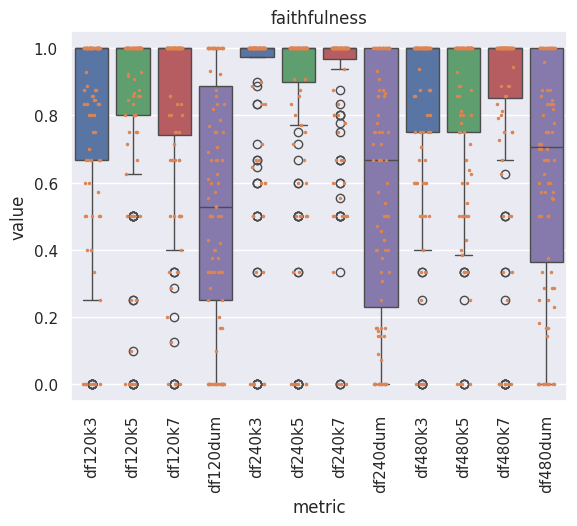

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


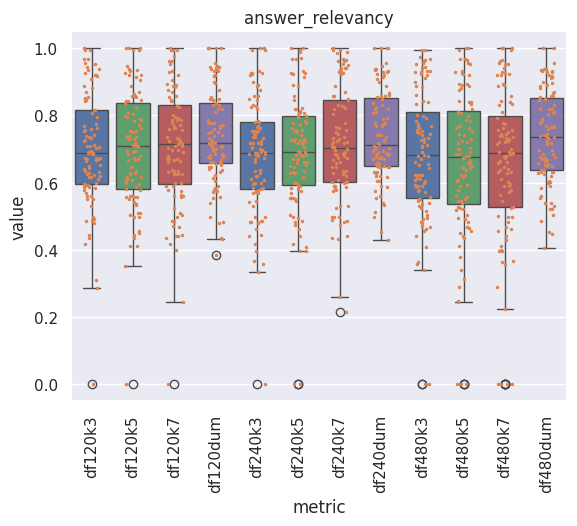

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


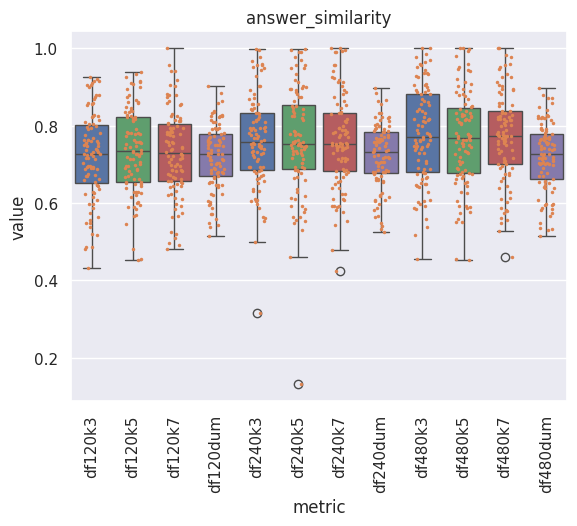

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


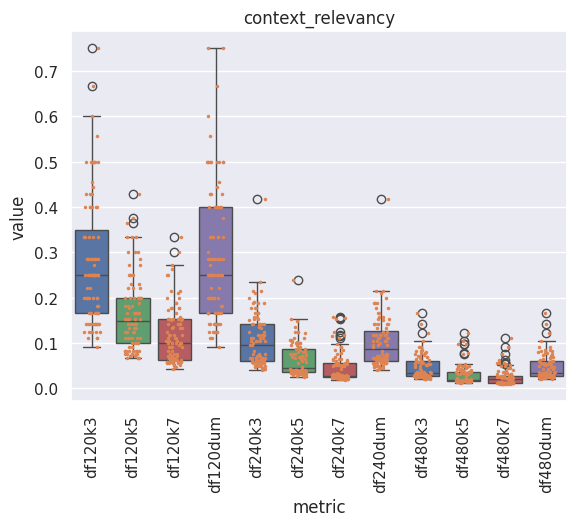

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


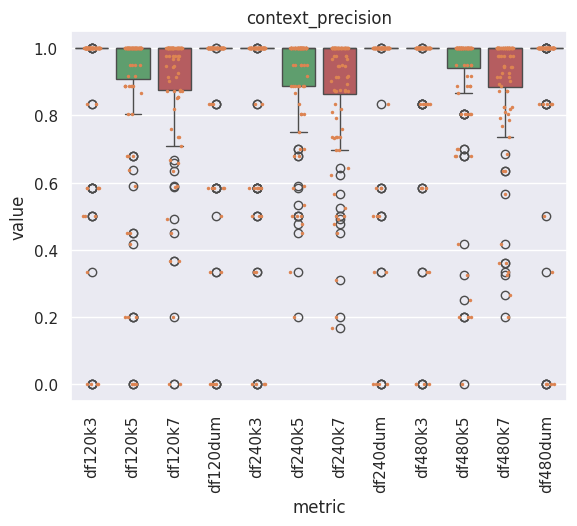

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


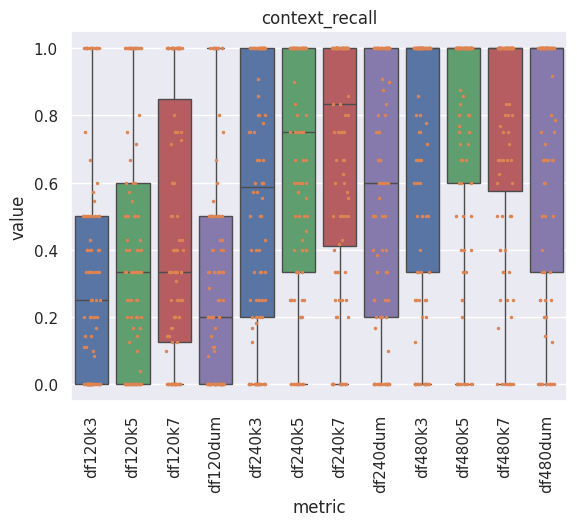

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


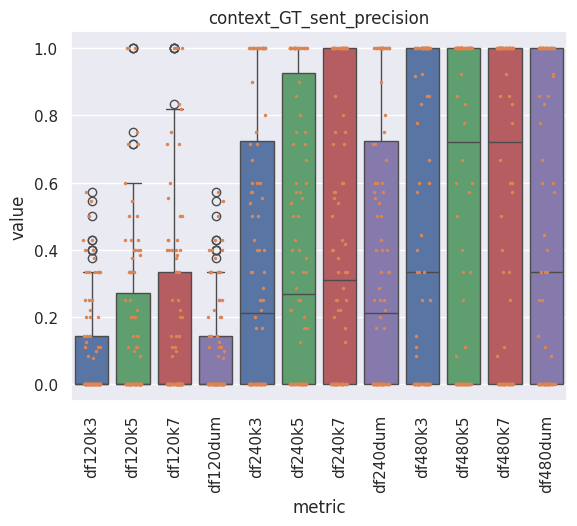

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


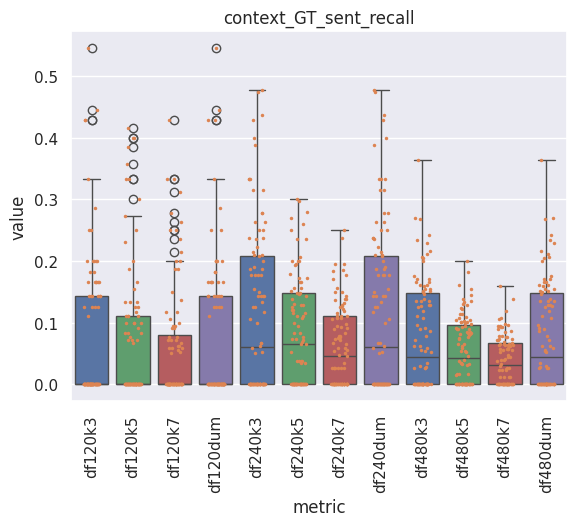

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


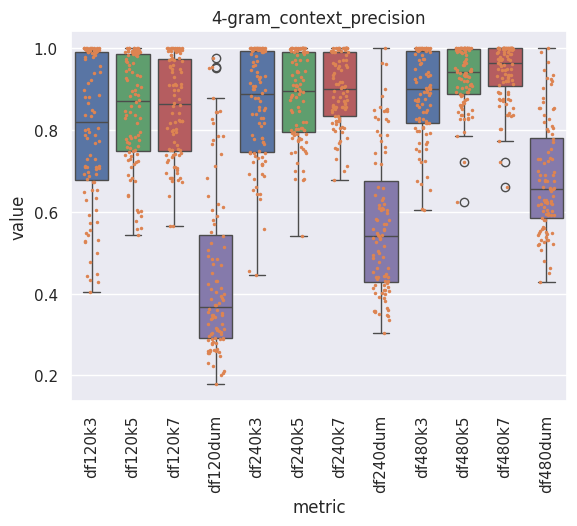

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


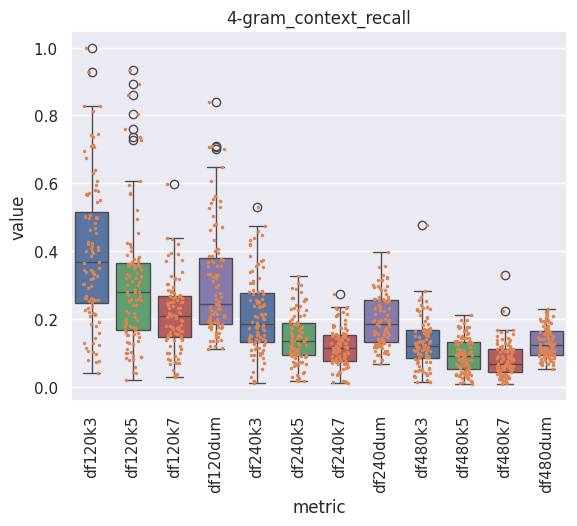

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


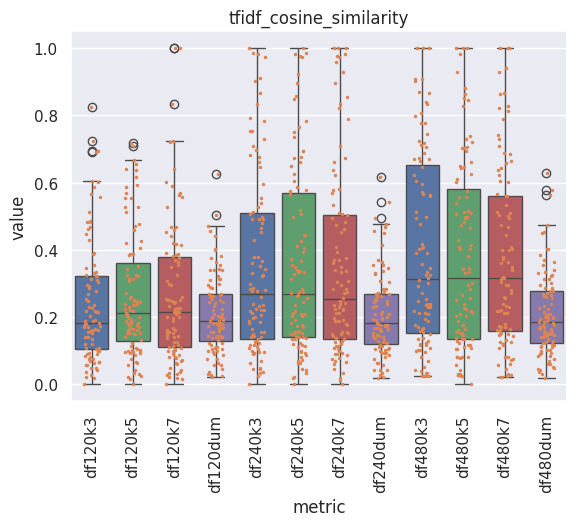

In [66]:
for x in df120dum.columns[4:]:
    box_plot(full_monty, x)

In [67]:
QA_stats = []
passage_stats = []
misleading_q_stats = []

for i in full_monty:
    passage_df = i[0:60]
    passage_df.name = i.name
    QA_df = i[60:91]
    QA_df.name = i.name
    misleading_q_df = i[91:]
    misleading_q_df.name = i.name
    passage_stats.append(passage_df)
    QA_stats.append(QA_df)
    misleading_q_stats.append(misleading_q_df)

# sanity check
print(passage_stats[0].shape, QA_stats[0].shape, misleading_q_stats[0].shape)

(60, 15) (31, 15) (5, 15)


Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


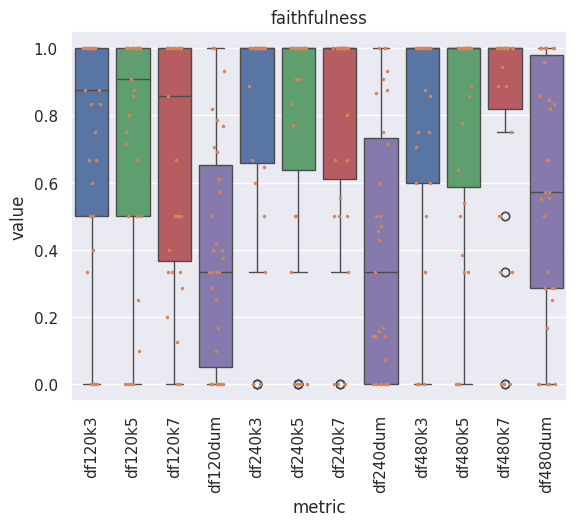

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


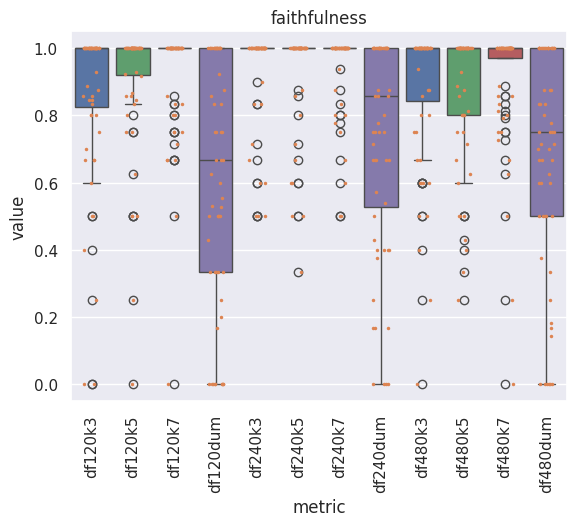

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


Misleading Questions


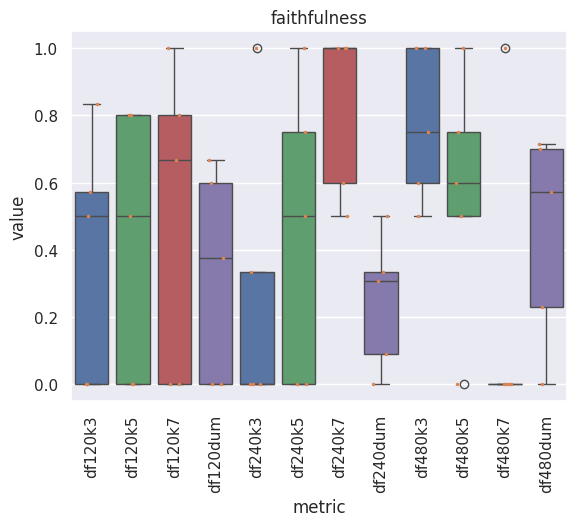

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


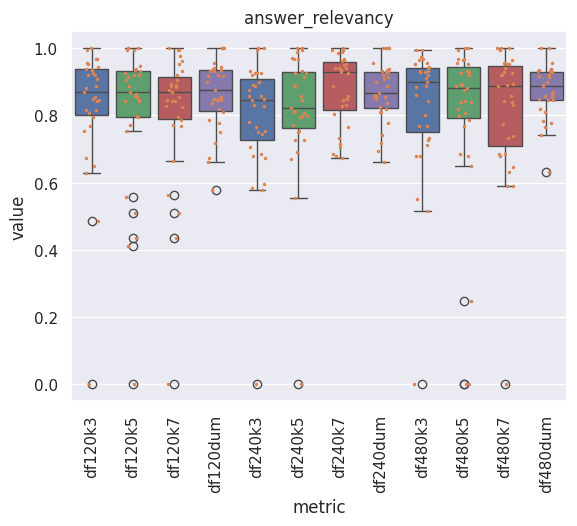

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


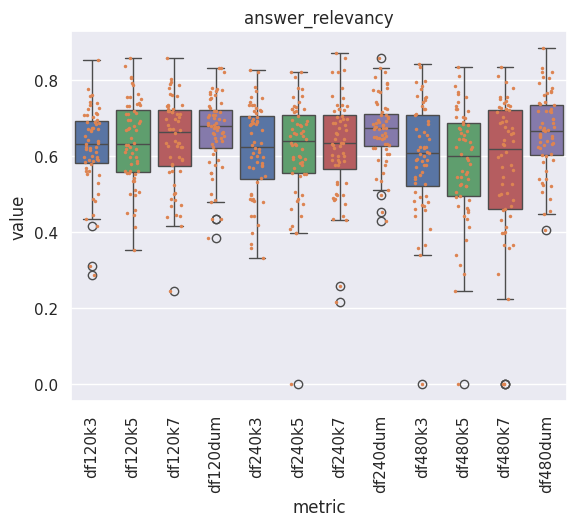

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


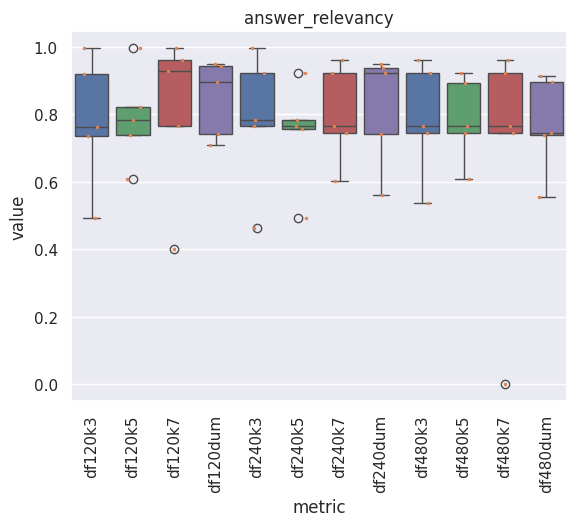

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


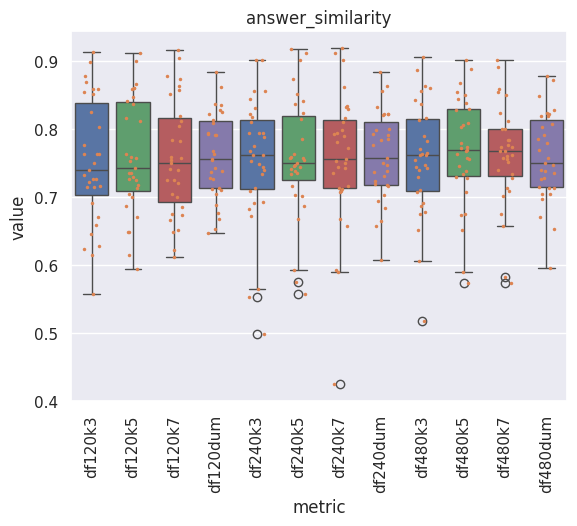

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


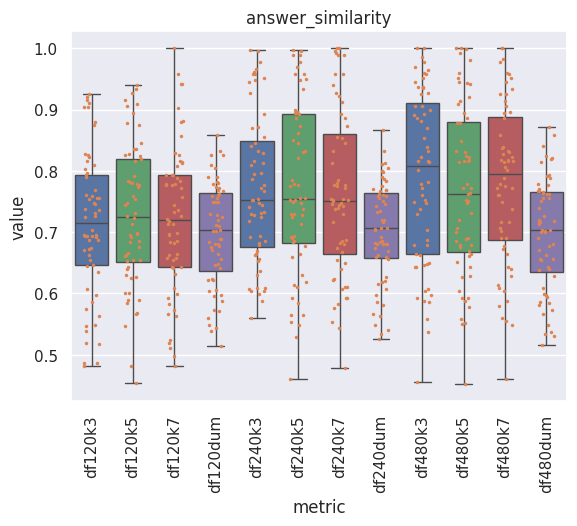

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


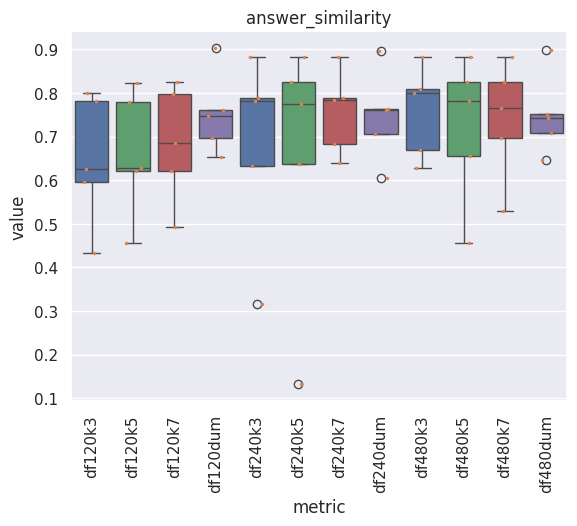

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


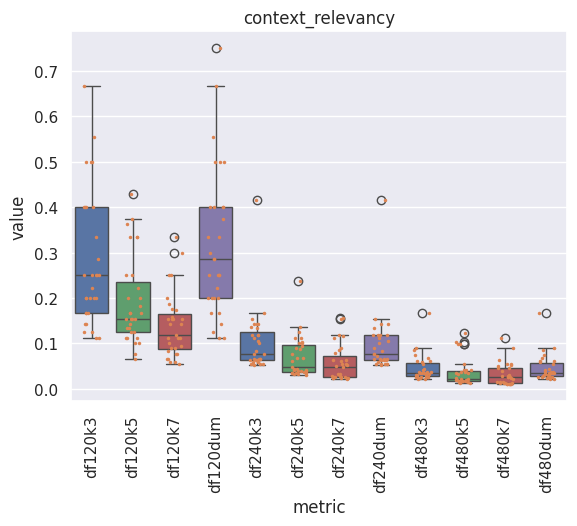

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


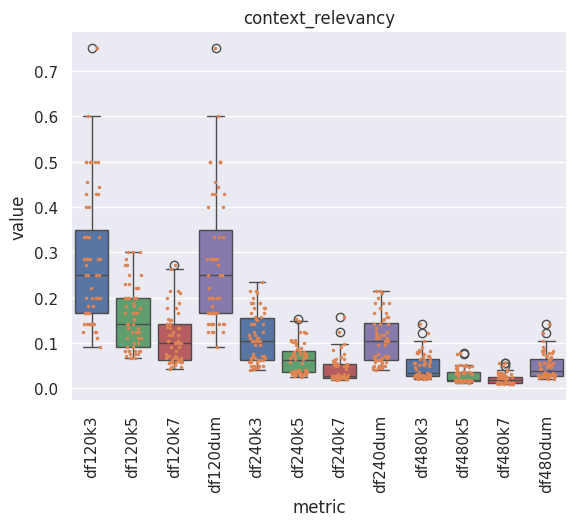

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


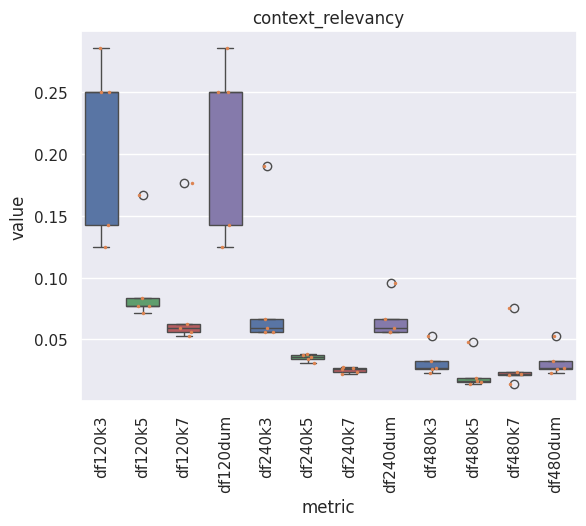

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


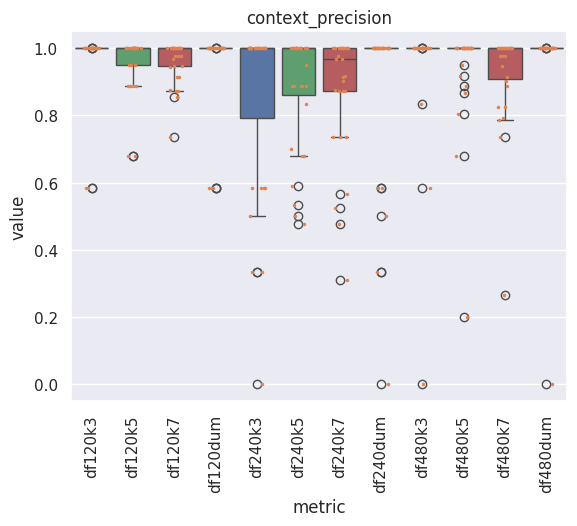

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


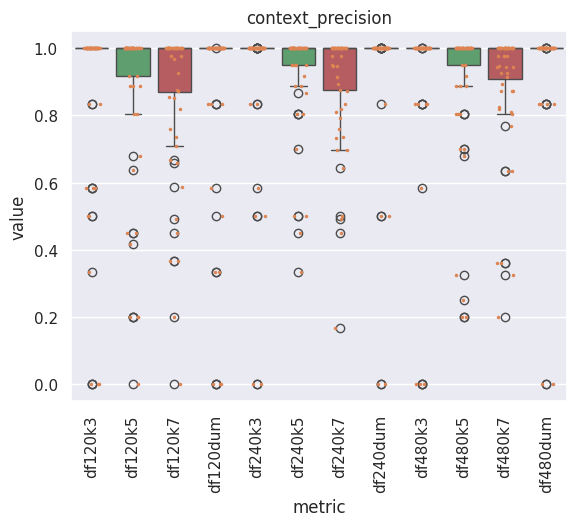

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


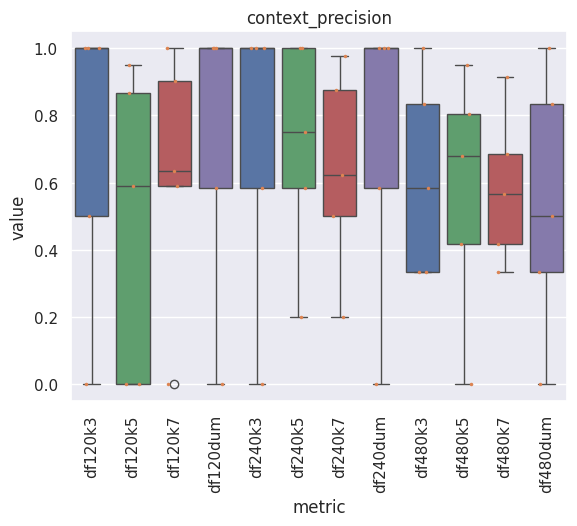

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


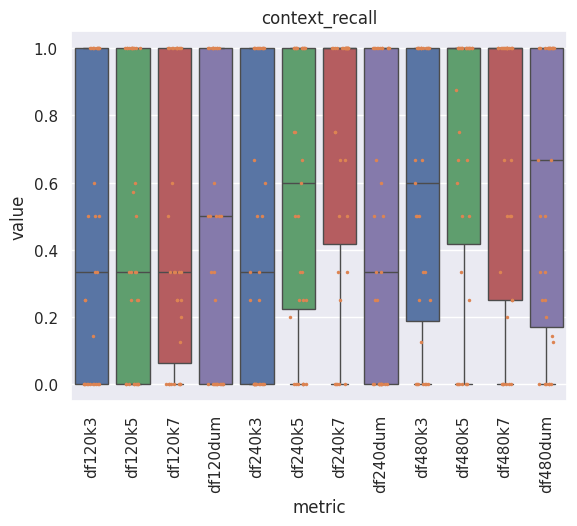

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


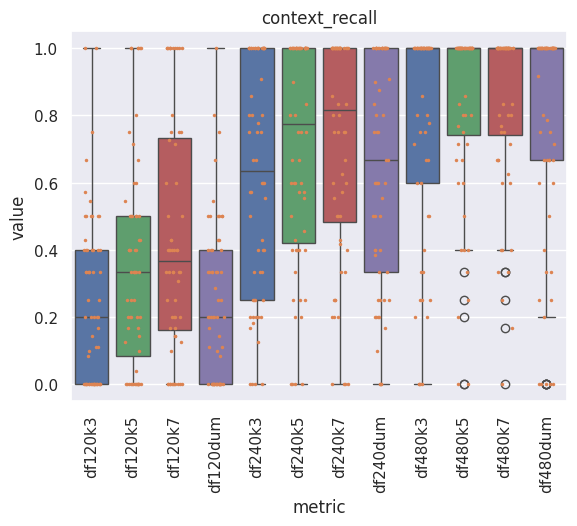

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


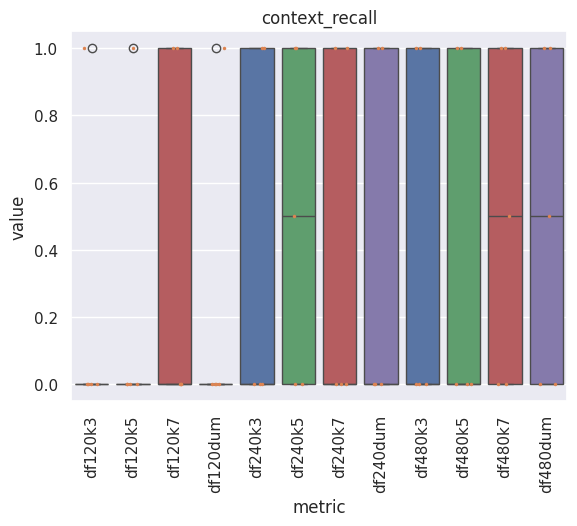

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


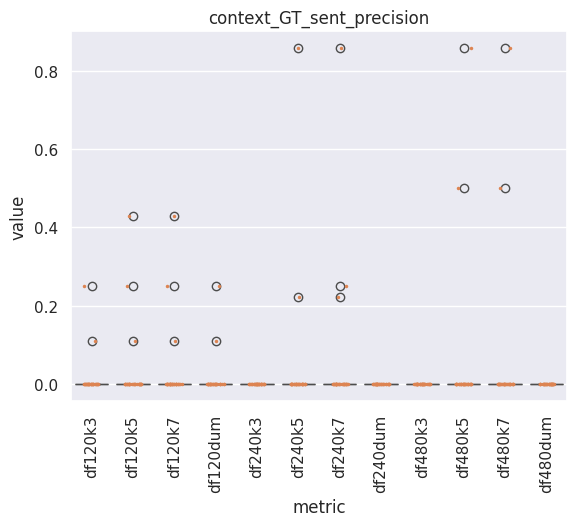

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


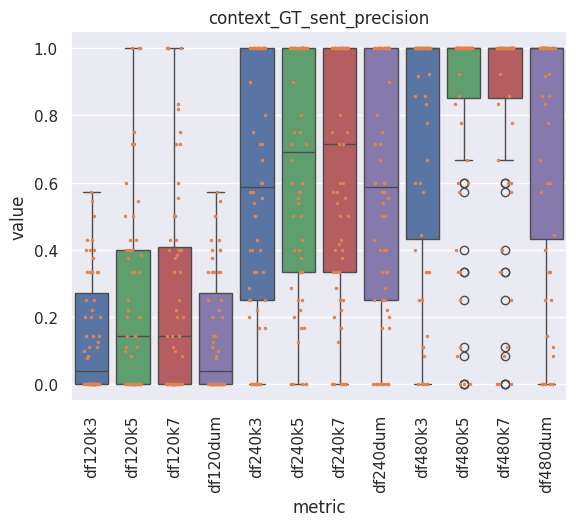

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


Misleading Questions


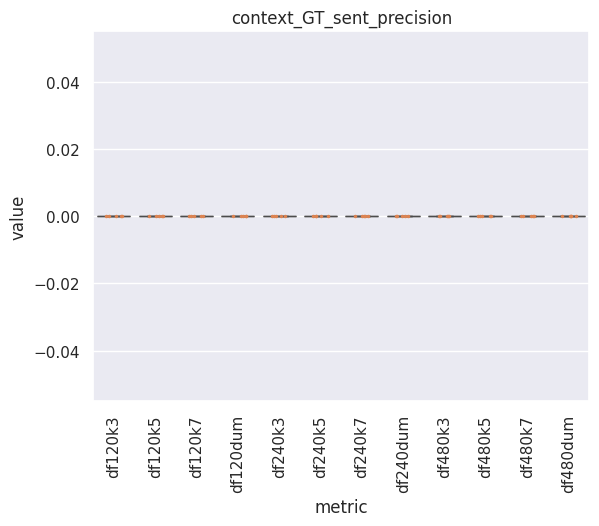

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


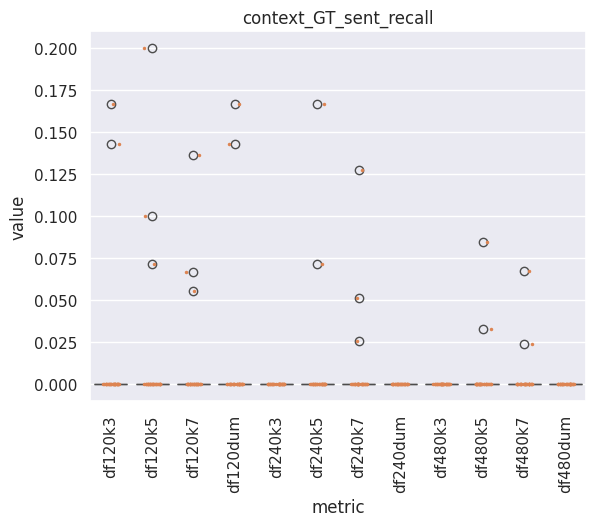

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


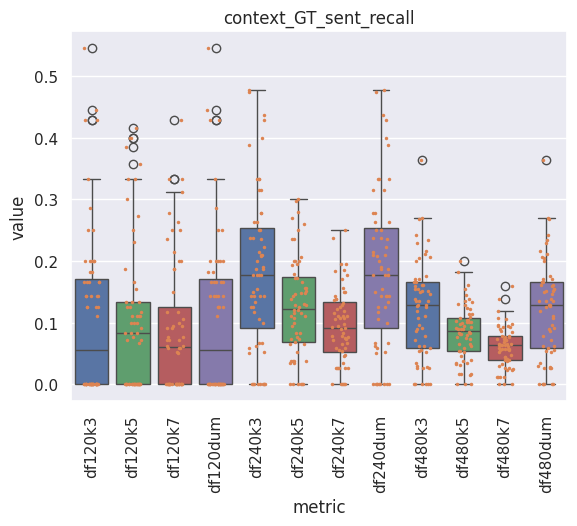

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


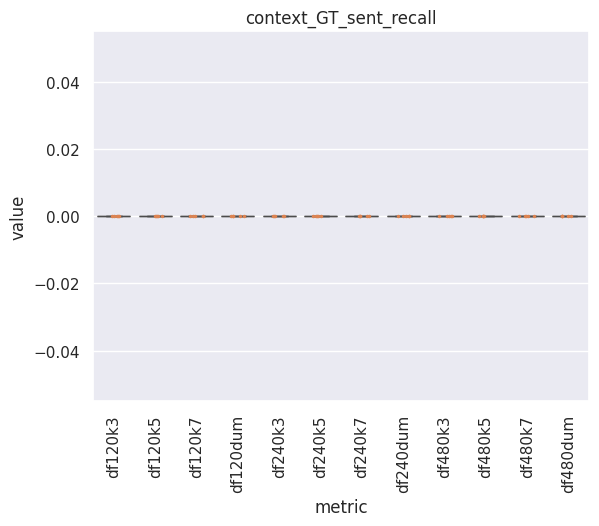

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


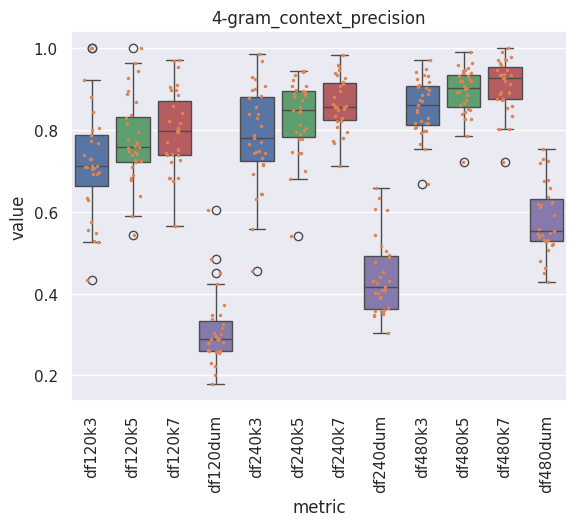

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


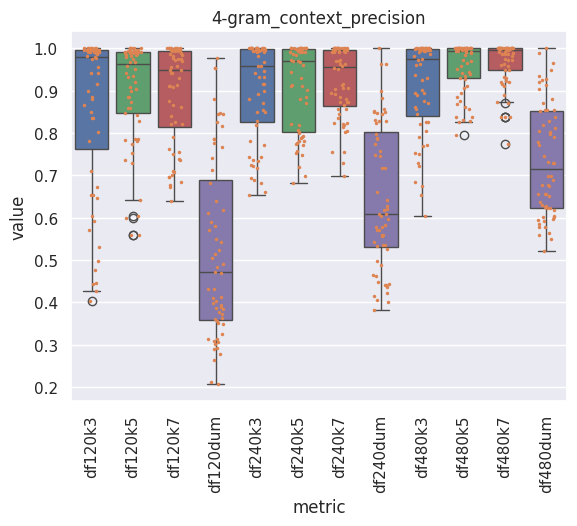

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


Misleading Questions


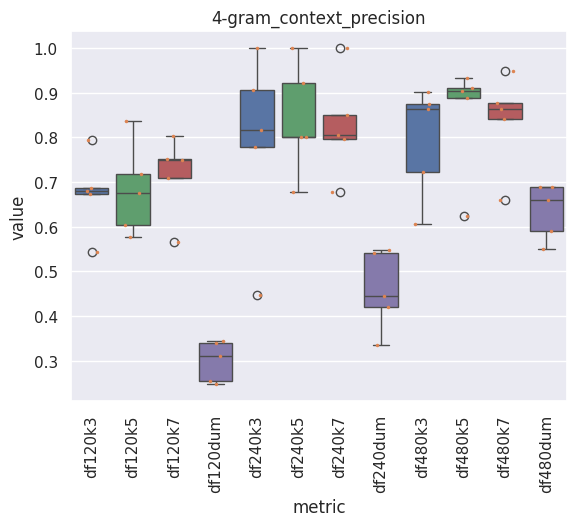

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


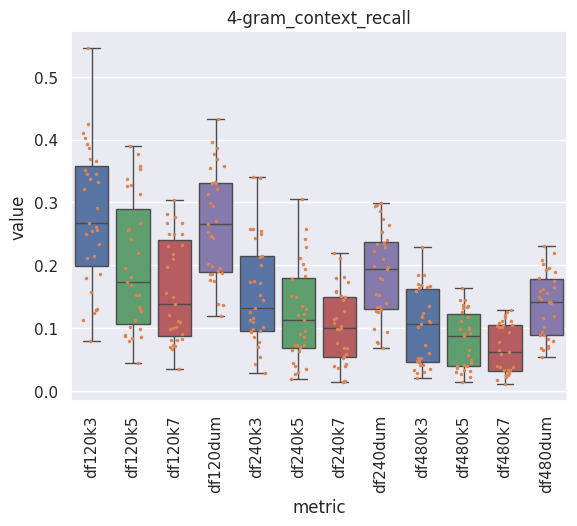

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


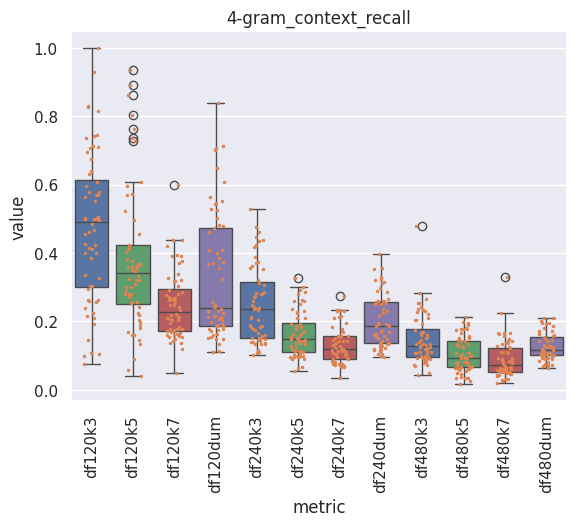

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


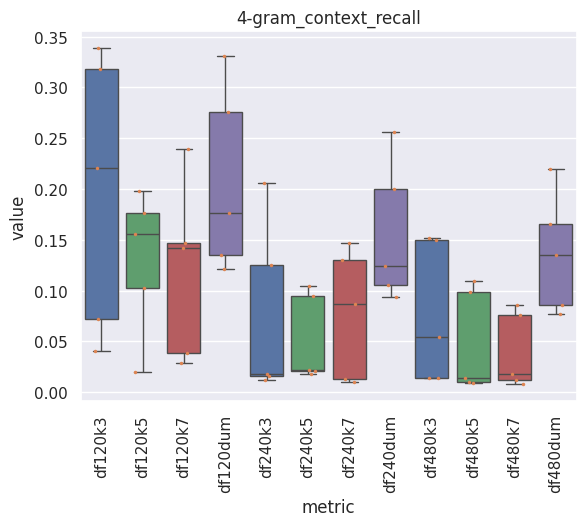

Question & Answer


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


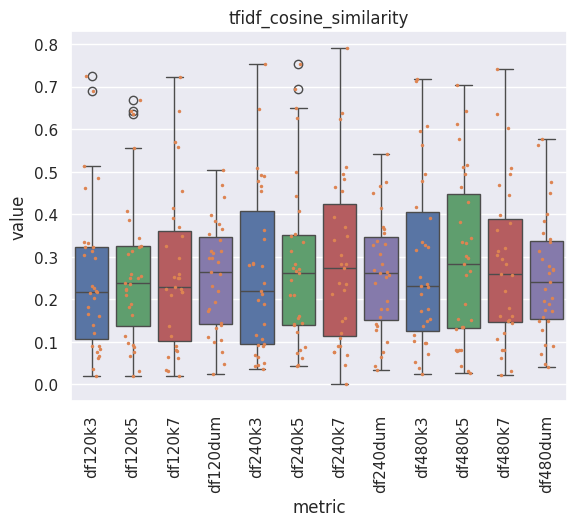

Passage Continuation


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


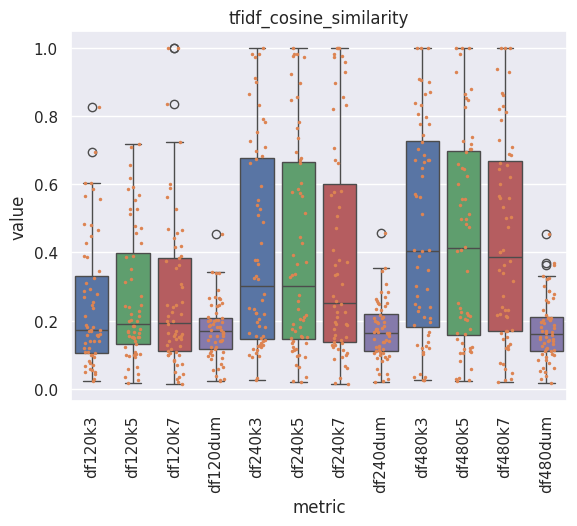

Misleading Questions


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


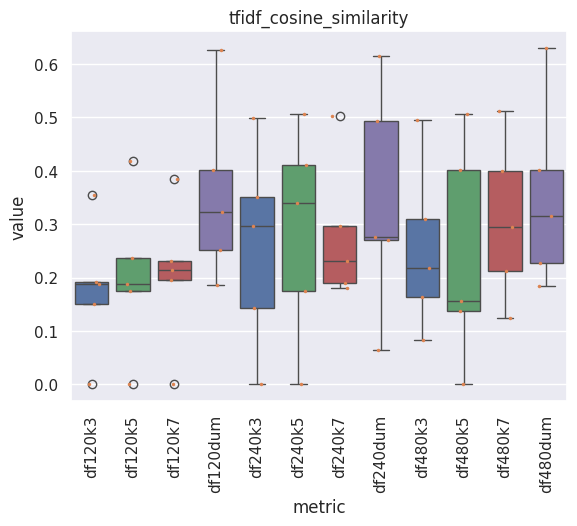

In [68]:
for i in df120dum.columns[4:]:
    print("Question & Answer")
    box_plot(QA_stats, i)
    print("Passage Continuation")
    box_plot(passage_stats, i)
    print("Misleading Questions")
    box_plot(misleading_q_stats, i)

### Similarity Correlation

(192,)
(192, 3467)
['000' '10' '1000' ... 'α4glcnac' 'β1' 'β4galnac']
(96, 96)
PearsonRResult(statistic=0.16043960101719223, pvalue=0.3885852526891407)
SignificanceResult(statistic=0.18391617561502685, pvalue=0.3219770977654912)


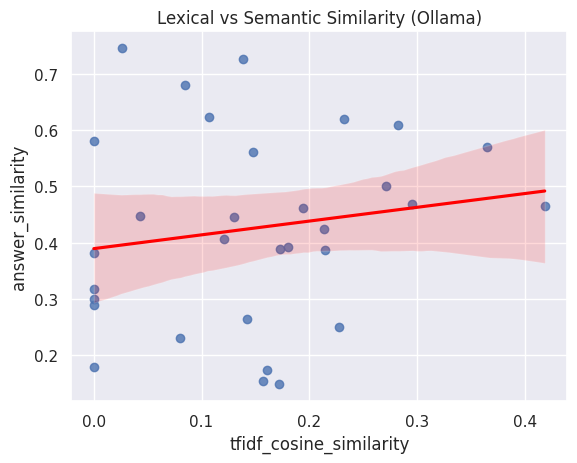

In [69]:
ollama = pd.read_csv('./results/ollama-4/ragas_curated.csv')
ollama = custom_metrics(ollama)
ollamaQA = ollama[60:91]
ollamaQA.name = 'ollamaQA'

# correlation plot
plot = sns.regplot(x='tfidf_cosine_similarity', y='answer_similarity', data=ollamaQA, line_kws={'color':'red'})
plot.set(title='Lexical vs Semantic Similarity (Ollama)')
print(pearsonr(ollamaQA['tfidf_cosine_similarity'], ollamaQA['answer_similarity']))
print(spearmanr(ollamaQA['tfidf_cosine_similarity'], ollamaQA['answer_similarity']))

PearsonRResult(statistic=0.6613912538848278, pvalue=5.098833534986371e-05)
SignificanceResult(statistic=0.6758064516129033, pvalue=3.017872657358296e-05)


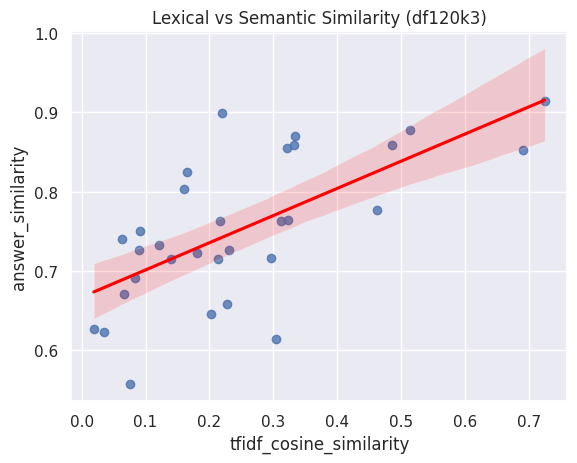

PearsonRResult(statistic=0.5616904572225788, pvalue=0.0010090570875055701)
SignificanceResult(statistic=0.5161290322580646, pvalue=0.0029567259704205064)


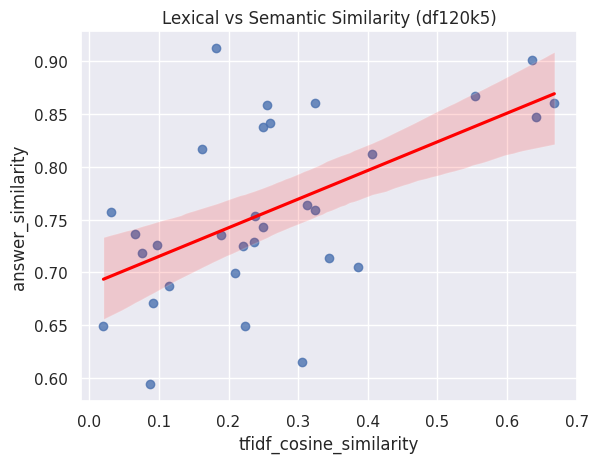

PearsonRResult(statistic=0.5870233610547899, pvalue=0.0005177474249831157)
SignificanceResult(statistic=0.5625, pvalue=0.0009885776702318481)


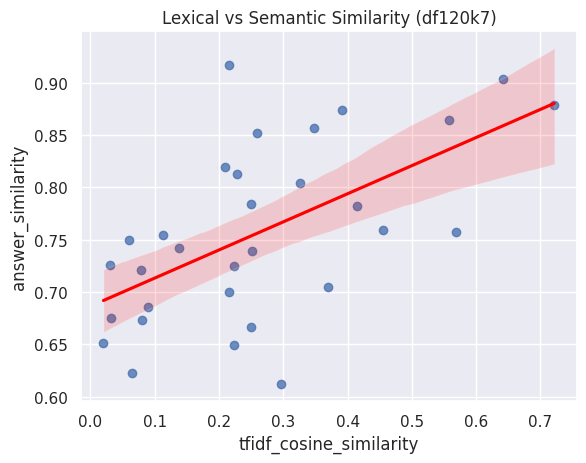

PearsonRResult(statistic=0.7315660981243265, pvalue=2.929499516721e-06)
SignificanceResult(statistic=0.7346774193548389, pvalue=2.5295107780101792e-06)


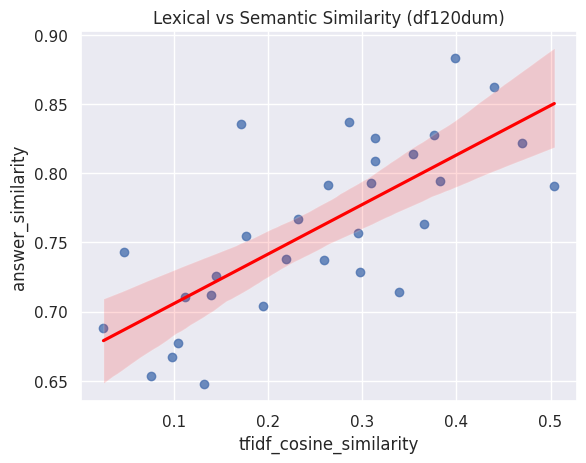

PearsonRResult(statistic=0.627657546753186, pvalue=0.00015707939115522002)
SignificanceResult(statistic=0.6971774193548388, pvalue=1.3126325533015808e-05)


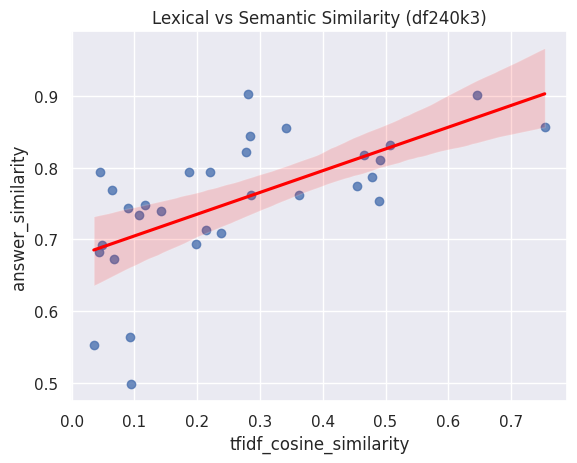

PearsonRResult(statistic=0.6486030839716466, pvalue=7.937124220181166e-05)
SignificanceResult(statistic=0.6362903225806452, pvalue=0.0001192802371147856)


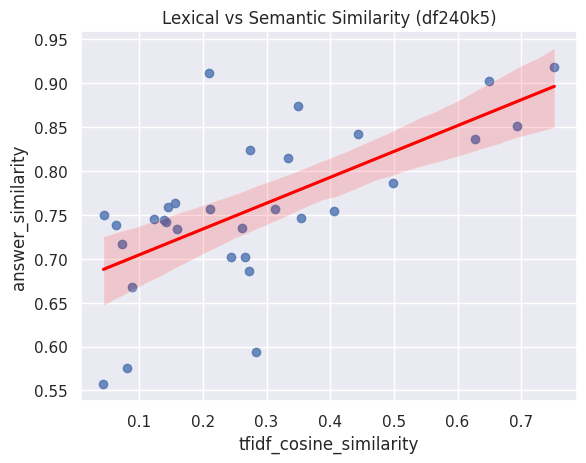

PearsonRResult(statistic=0.6304541707518592, pvalue=0.0001438076531417363)
SignificanceResult(statistic=0.6786290322580647, pvalue=2.7141863544367876e-05)


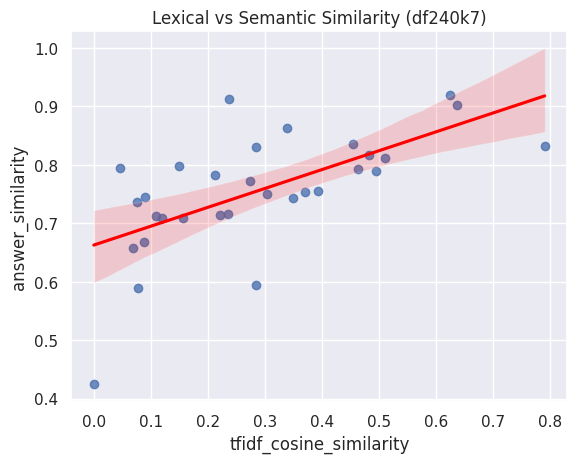

PearsonRResult(statistic=0.7221044830974226, pvalue=4.523466110341551e-06)
SignificanceResult(statistic=0.7129032258064517, pvalue=6.789174788259863e-06)


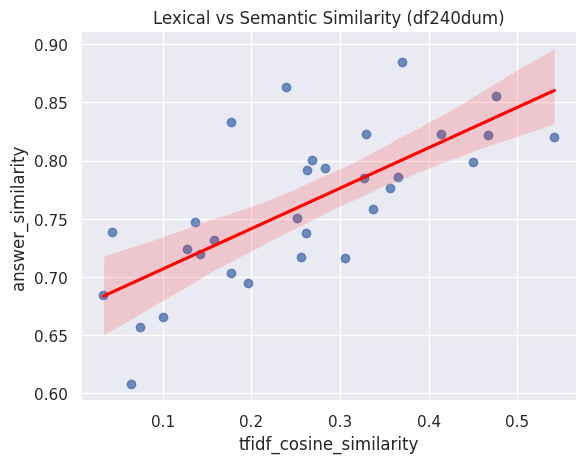

PearsonRResult(statistic=0.7264604616951482, pvalue=3.7116035931915827e-06)
SignificanceResult(statistic=0.7806451612903227, pvalue=2.2180320220159952e-07)


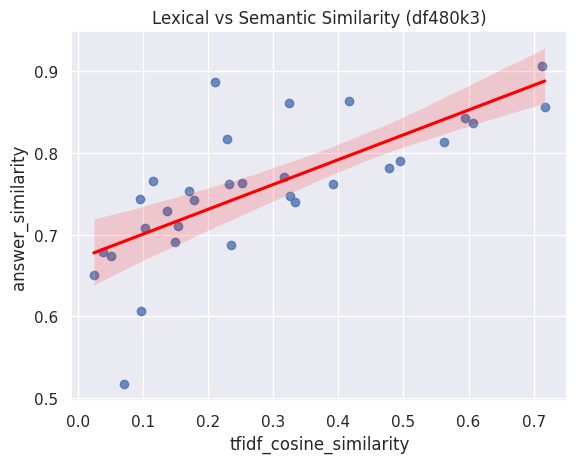

PearsonRResult(statistic=0.7484279353659663, pvalue=1.2895212068337146e-06)
SignificanceResult(statistic=0.822983870967742, pvalue=1.3264543258875202e-08)


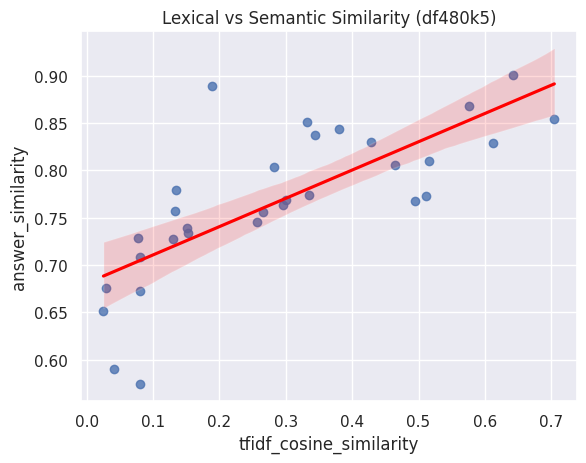

PearsonRResult(statistic=0.6062700589166548, pvalue=0.0003002678844293904)
SignificanceResult(statistic=0.6963709677419355, pvalue=1.3562596171927883e-05)


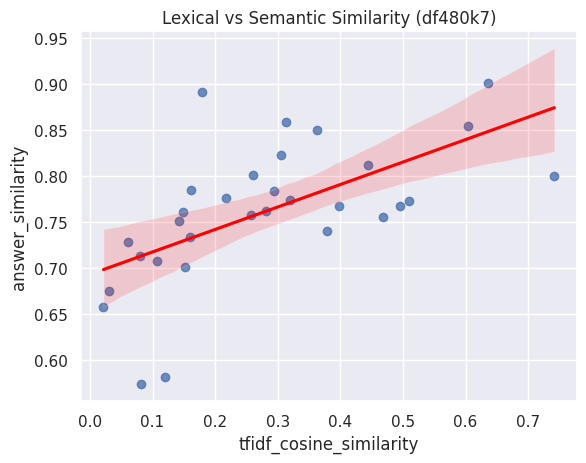

PearsonRResult(statistic=0.7028930299973085, pvalue=1.0379638487149458e-05)
SignificanceResult(statistic=0.7229838709677421, pvalue=4.347668072764423e-06)


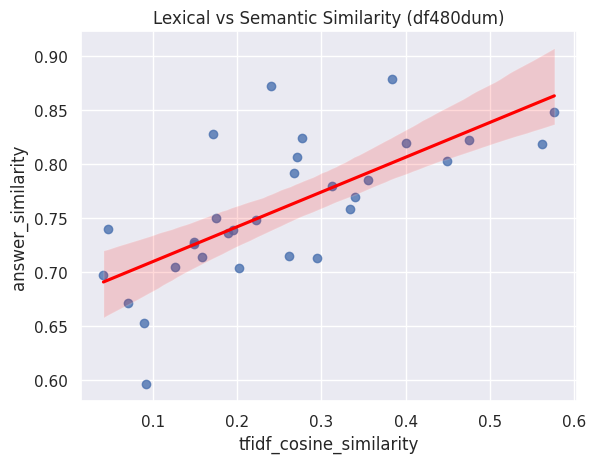

In [70]:
# correlation plot
def correlation_plot(df: pd.DataFrame, title=None):
    if title is None:
        title = df.name
    plot = sns.regplot(x='tfidf_cosine_similarity', y='answer_similarity', data=df, line_kws={'color':'red'})
    plot.set(title=f'Lexical vs Semantic Similarity ({title})')
    print(pearsonr(df['tfidf_cosine_similarity'], df['answer_similarity']))
    print(spearmanr(df['tfidf_cosine_similarity'], df['answer_similarity']))
    plt.show()

for i in QA_stats:
    correlation_plot(i)

# Normalization
**Examining distributions after normalizing to (0:1) with MinMaxScaler**

In [71]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

for i, df in enumerate(full_monty):
    for col in df.columns[4:]:
        df[col] = scaler.fit_transform(df[col].values.reshape(-1,1))

for i, col in enumerate(ollamaQA):
    if i < 5:
        continue
    else:
        ollamaQA[col] = scaler.fit_transform(ollamaQA[col].values.reshape(-1,1))

ollamaQA.describe()

/tmp/ipykernel_262527/2141506912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ollamaQA[col] = scaler.fit_transform(ollamaQA[col].values.reshape(-1,1))
/tmp/ipykernel_262527/2141506912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ollamaQA[col] = scaler.fit_transform(ollamaQA[col].values.reshape(-1,1))
/tmp/ipykernel_262527/2141506912.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

Unnamed: 0  faithfulness  answer_relevancy  answer_similarity  \
count   31.000000     30.000000         31.000000          31.000000   
mean    75.000000      0.459532          0.802477           0.463970   
std      9.092121      0.316514          0.205114           0.283901   
min     60.000000      0.000000          0.000000           0.000000   
25%     67.500000      0.221591          0.751877           0.243621   
50%     75.000000      0.479798          0.850270           0.463239   
75%     82.500000      0.693182          0.940820           0.697388   
max     90.000000      1.000000          1.000000           1.000000   

       context_relevancy  context_precision  context_recall  \
count          31.000000          31.000000       31.000000   
mean            0.403281           0.490950        0.616935   
std             0.230196           0.351343        0.428231   
min             0.000000           0.000000        0.000000   
25%             0.183333           0.250000        0.083333   
50%             0.366667           0.450000        0.750000   
75%             0.568333           0.804861        1.000000   
max             1.000000           1.000000        1.000000   

       context_GT_sent_precision  context_GT_sent_recall  \
count                       31.0                    31.0   
mean                         0.0                     0.0   
std                          0.0                     0.0   
min                          0.0                     0.0   
25%                          0.0                     0.0   
50%                          0.0                     0.0   
75%                          0.0                     0.0   
max                          0.0                     0.0   

       4-gram_context_precision  4-gram_context_recall  \
count                 31.000000              31.000000   
mean                   0.257144               0.232110   
std                    0.207316               0.184302   
min                    0.000000               0.000000   
25%                    0.167476               0.135908   
50%                    0.199094               0.215876   
75%                    0.272091               0.288026   
max                    1.000000               1.000000   

       tfidf_cosine_similarity  
count                31.000000  
mean                  0.352806  
std                   0.265665  
min                   0.000000  
25%                   0.146942  
50%                   0.352871  
75%                   0.511727  
max                   1.000000

### Normalized Results:

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


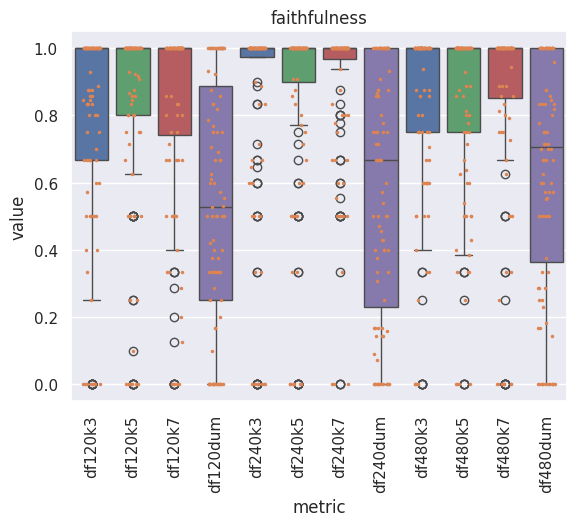

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


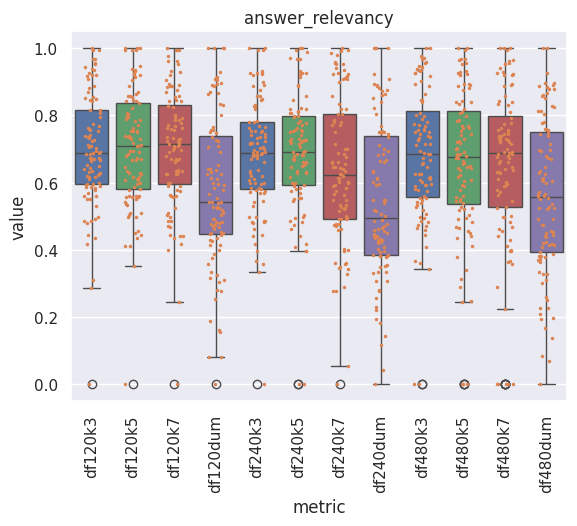

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


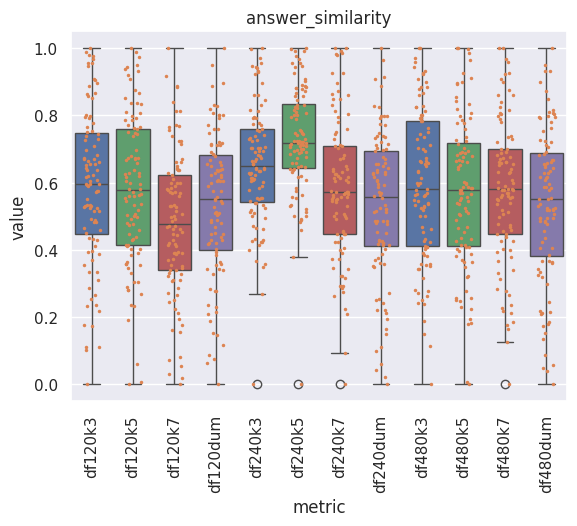

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


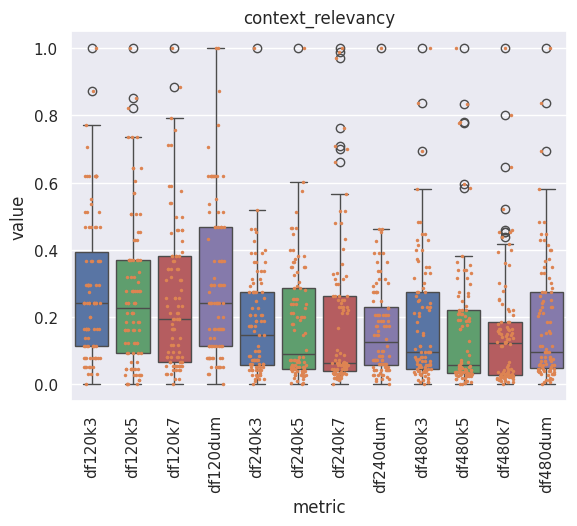

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


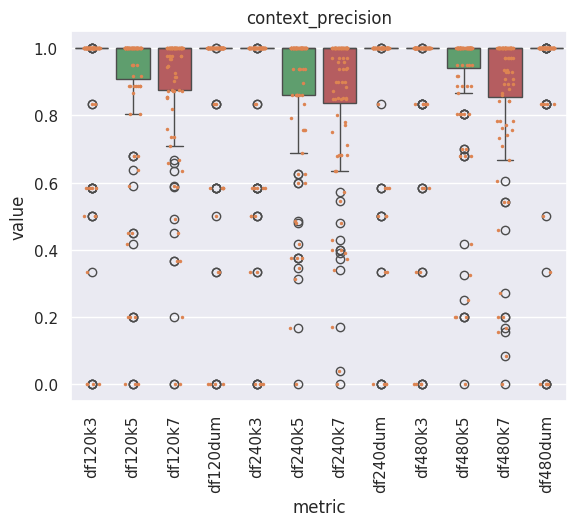

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


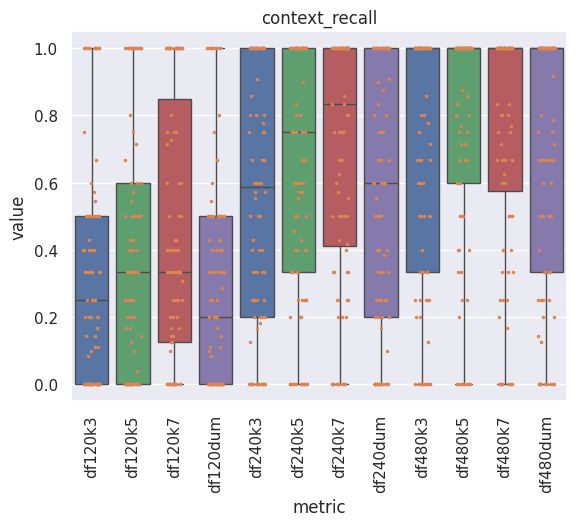

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


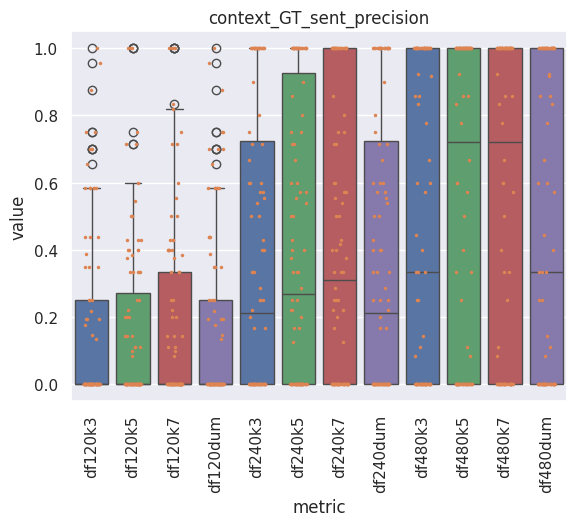

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


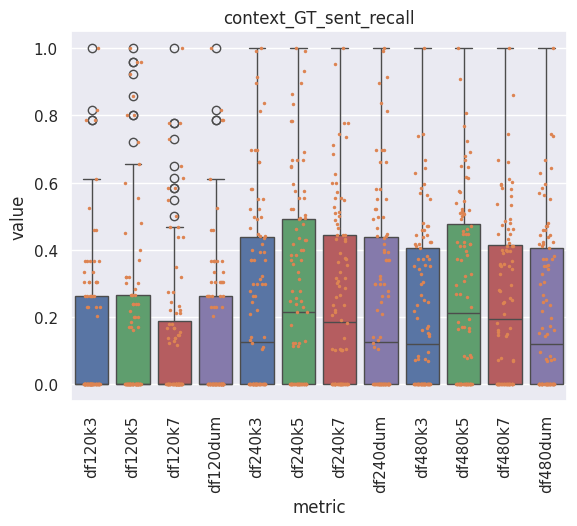

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


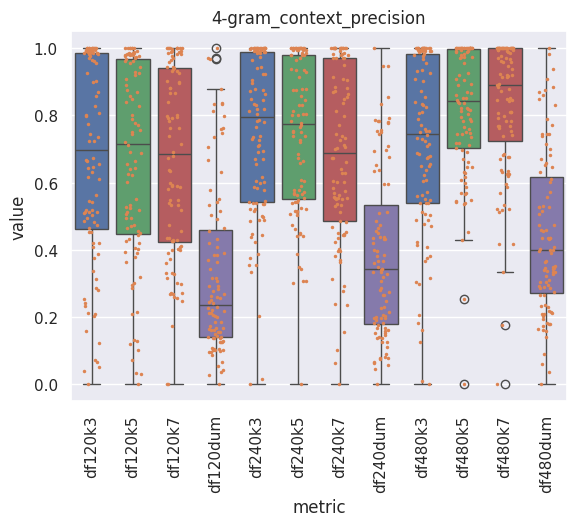

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


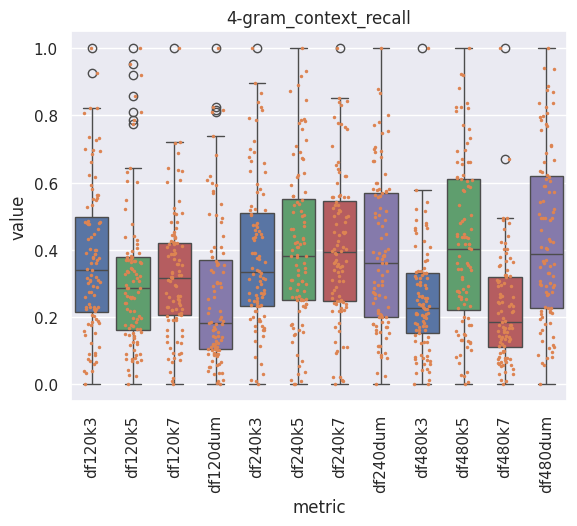

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


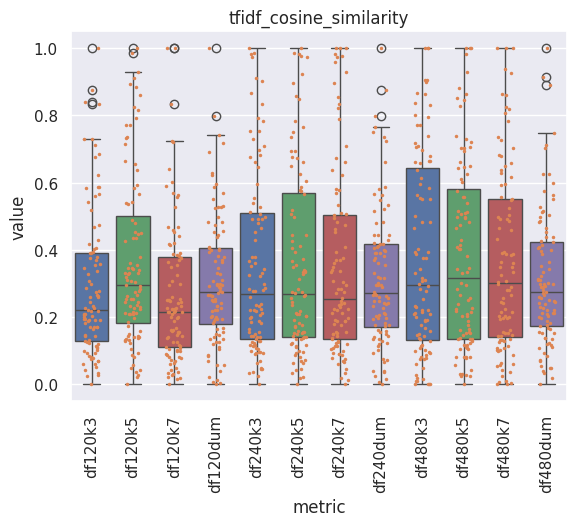

In [72]:
for x in df120dum.columns[4:]:
    box_plot(full_monty, x)

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


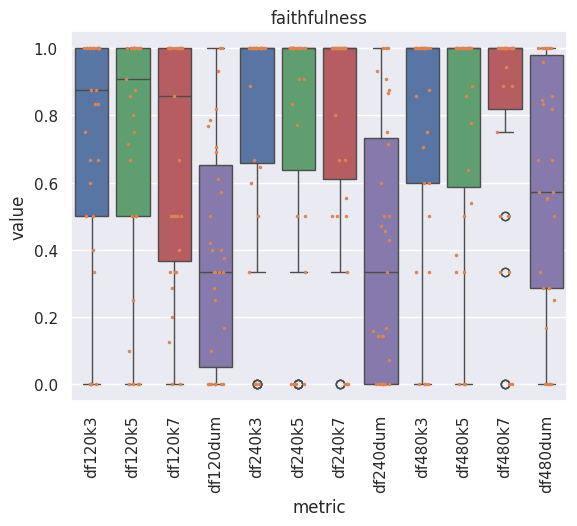

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


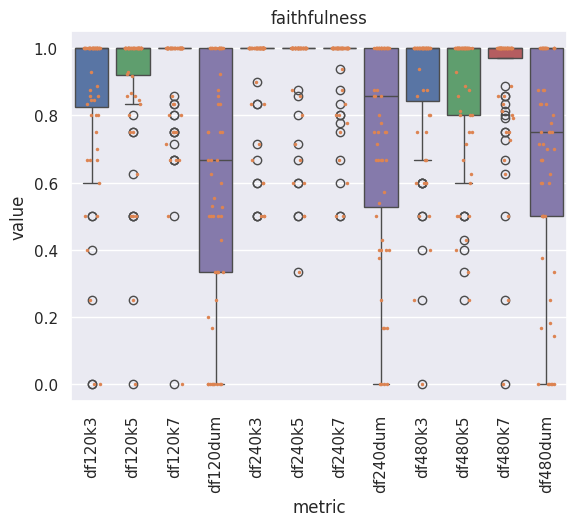

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


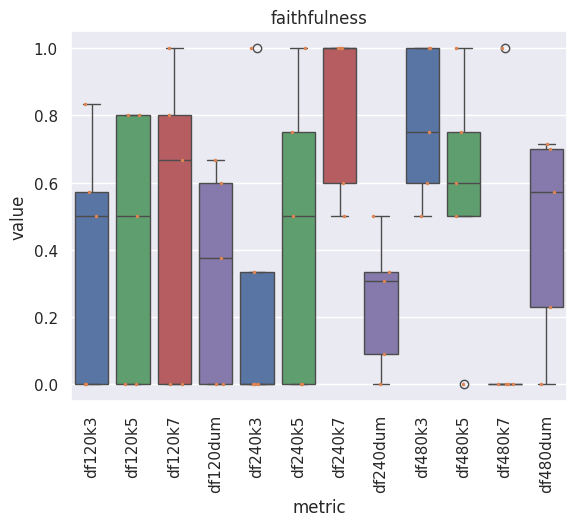

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


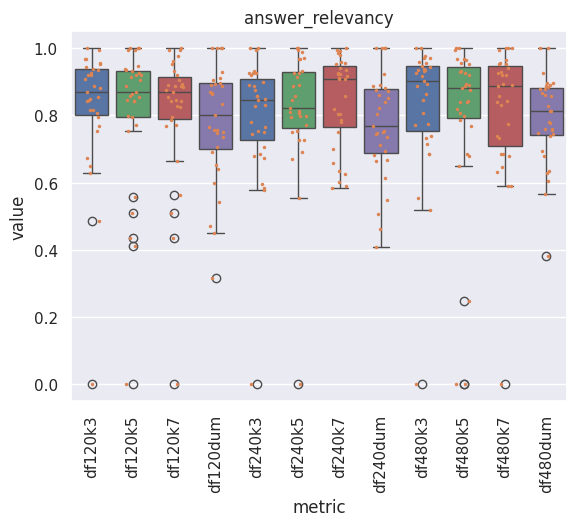

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


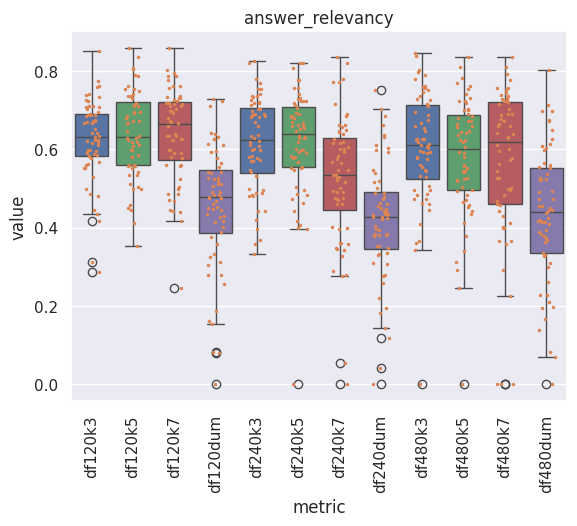

MISLEADING QUESTIONS


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


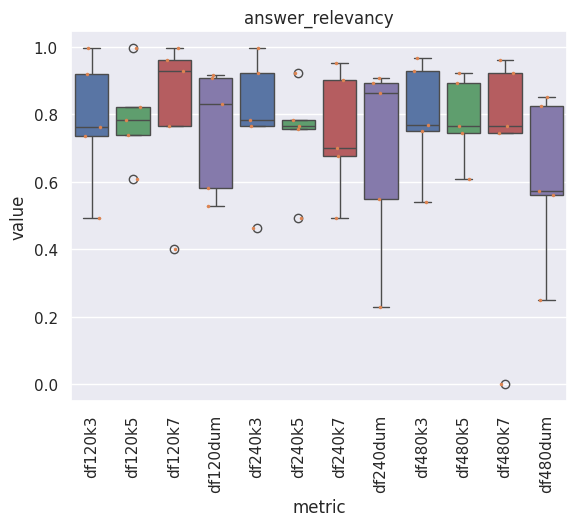

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


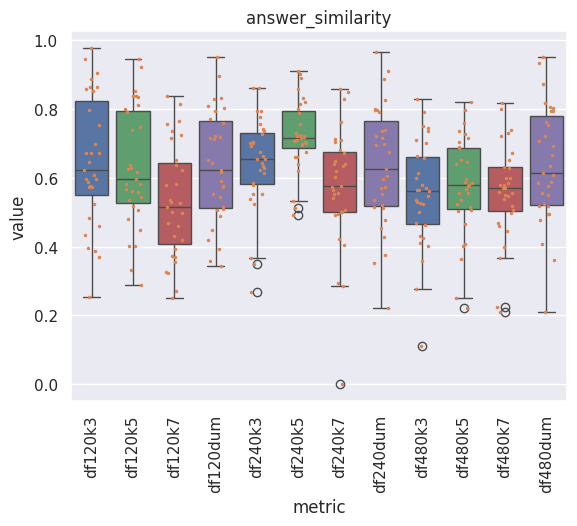

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


PASSAGE CONTINUATION


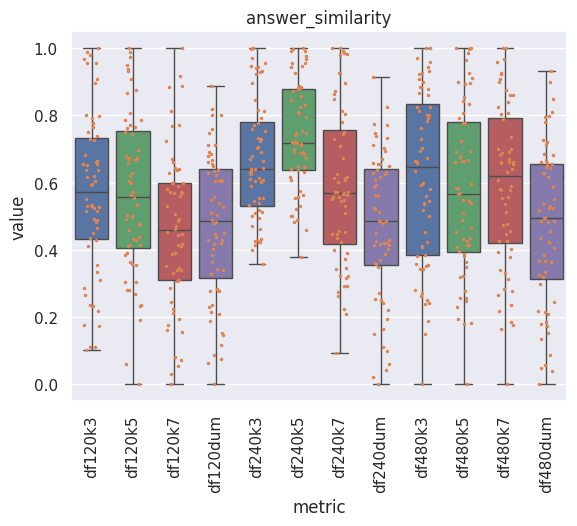

MISLEADING QUESTIONS


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


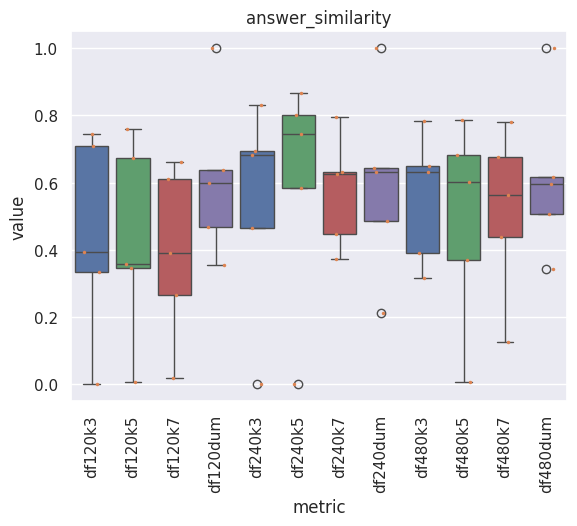

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


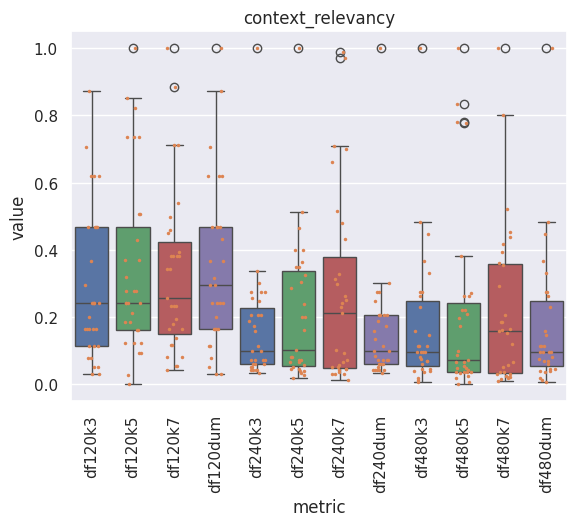

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


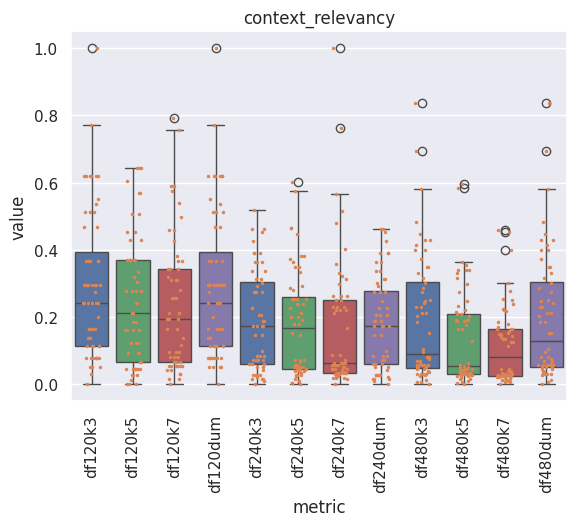

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


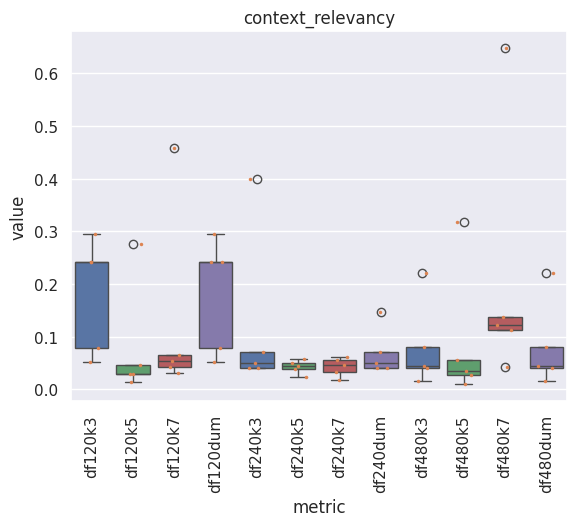

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


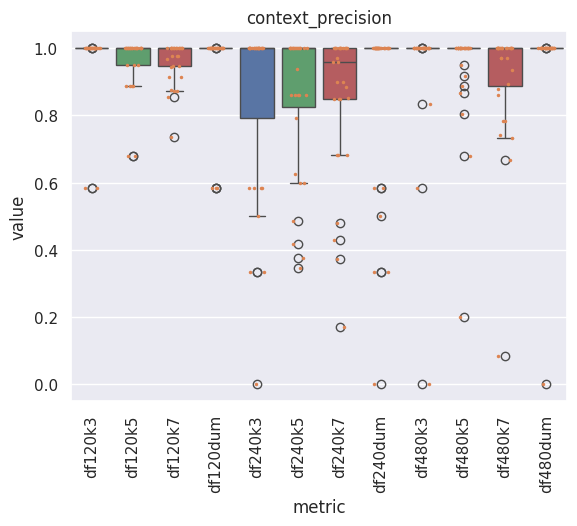

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


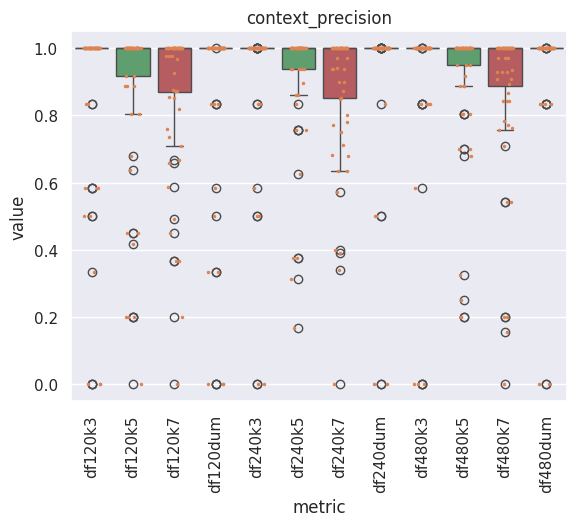

MISLEADING QUESTIONS


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


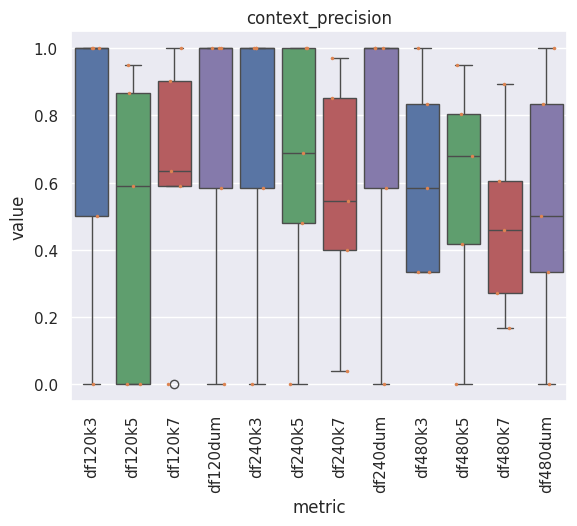

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


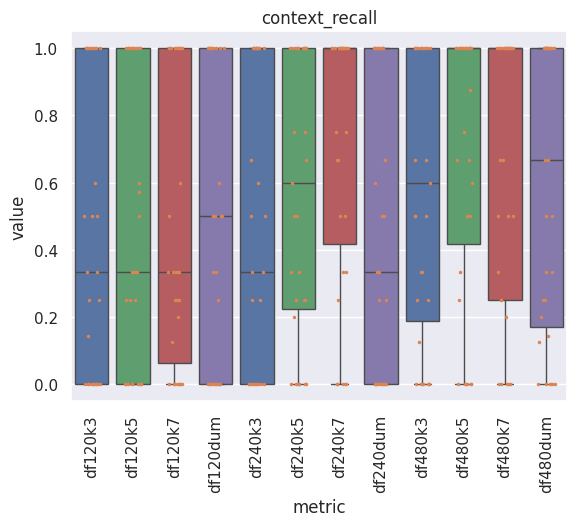

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


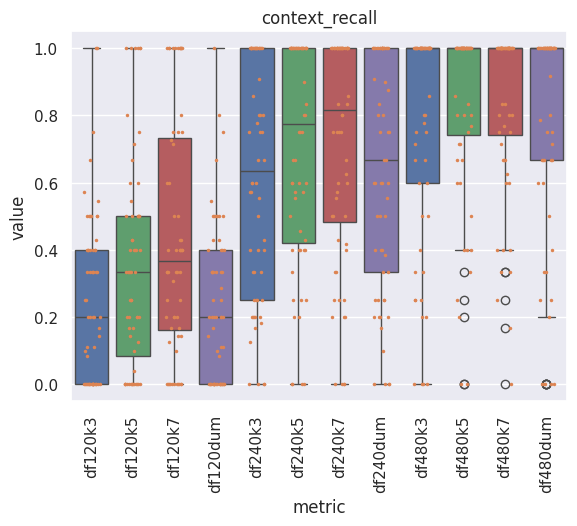

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


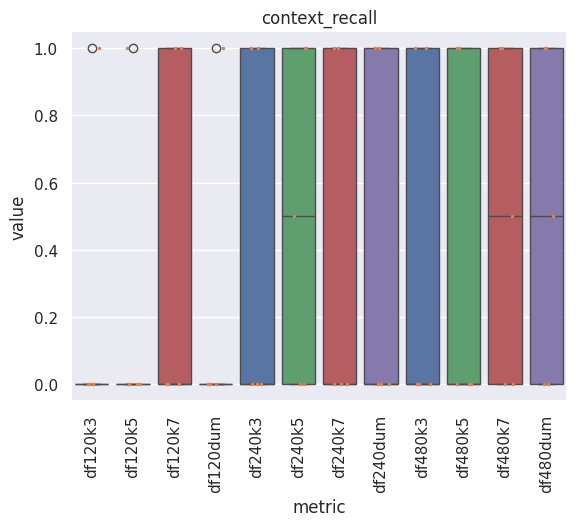

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


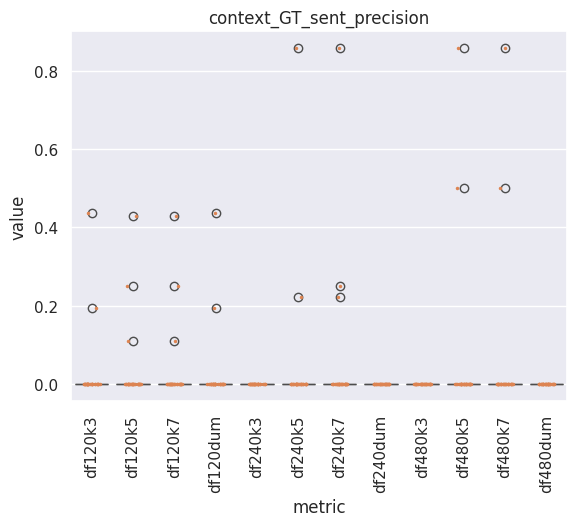

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


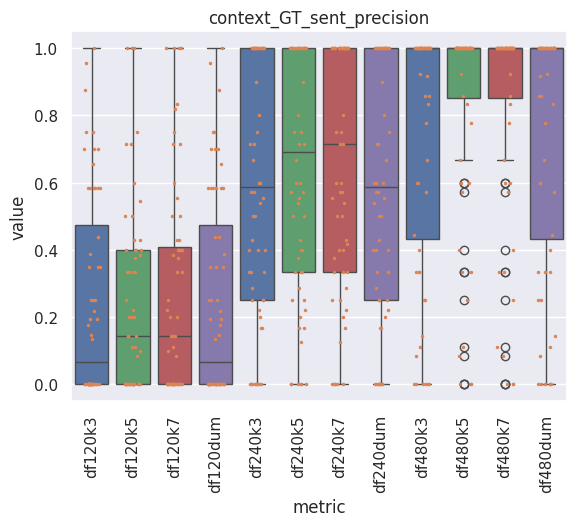

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


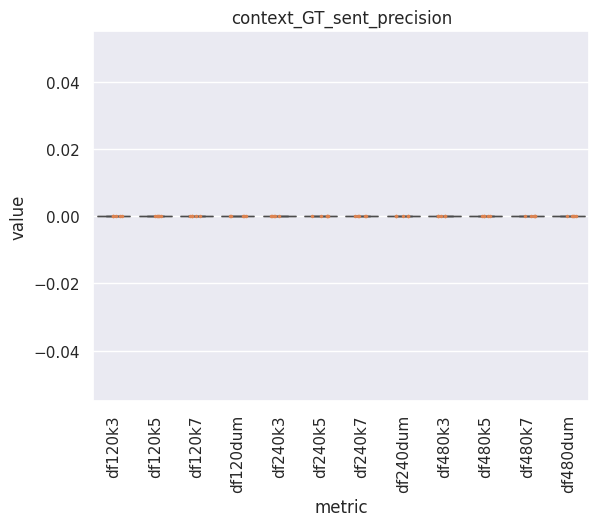

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


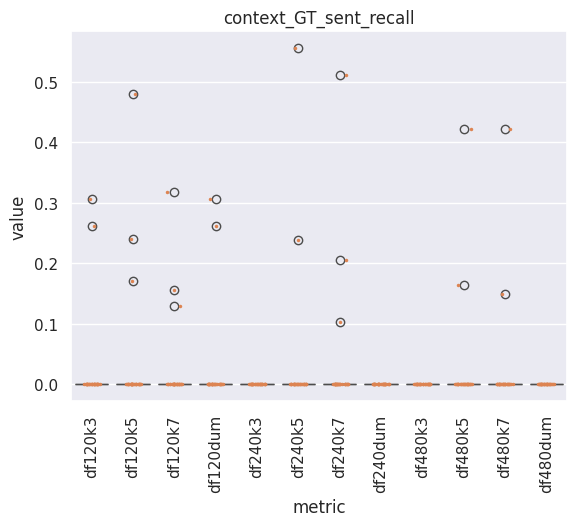

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


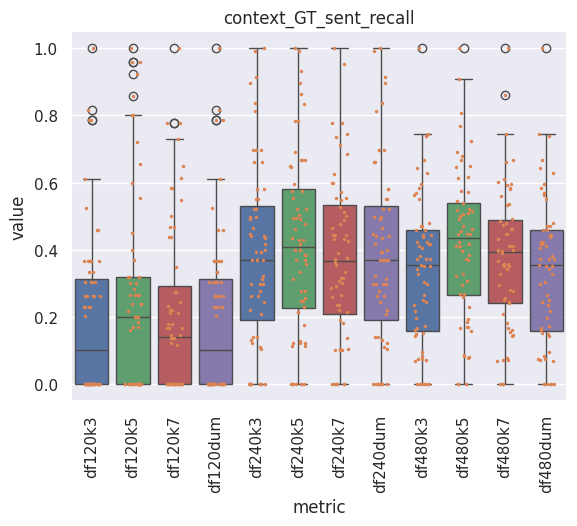

MISLEADING QUESTIONS


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


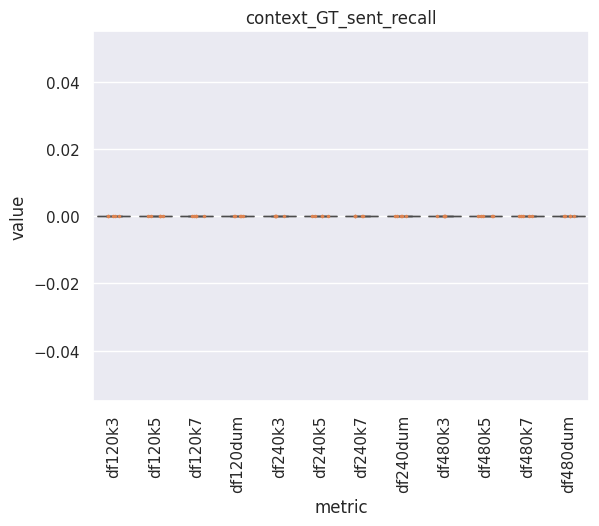

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


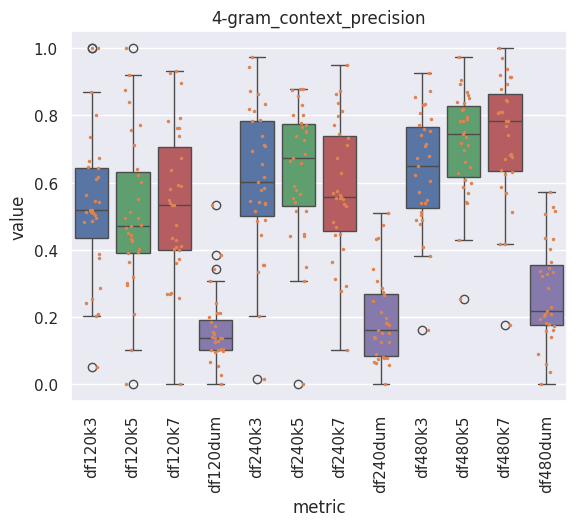

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


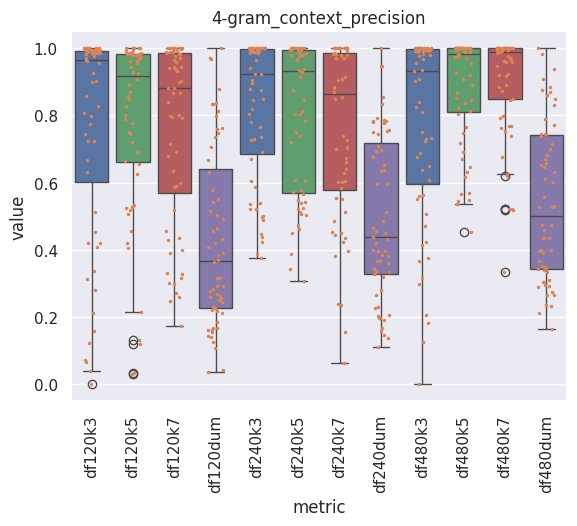

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


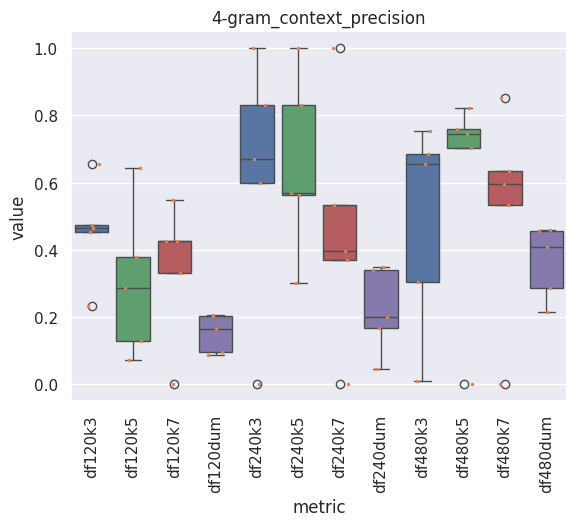

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


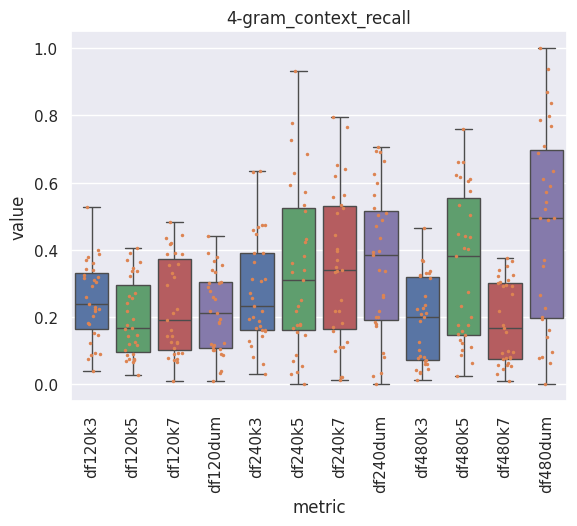

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


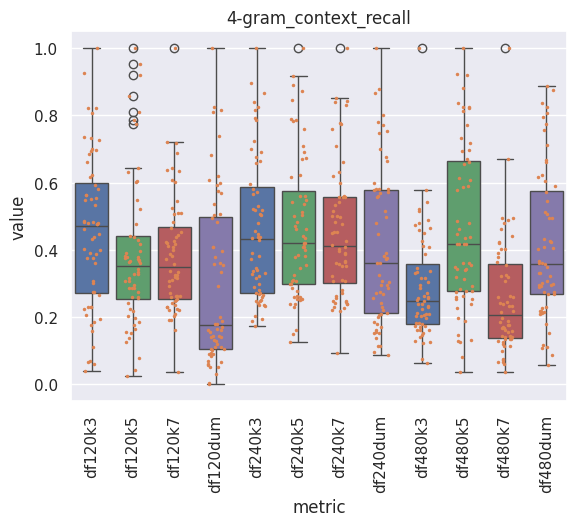

MISLEADING QUESTIONS


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


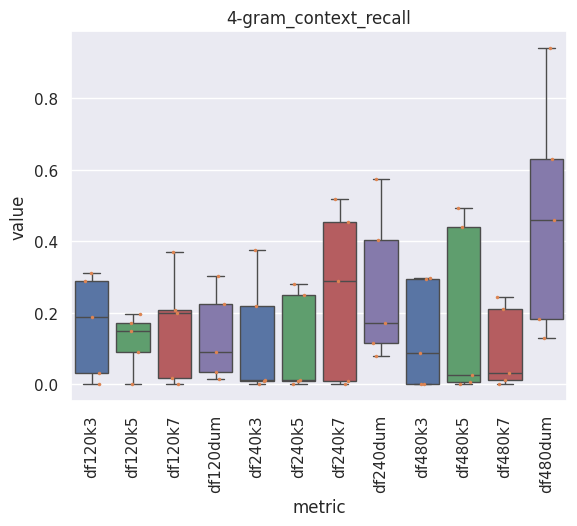

QUESTION & ANSWER


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


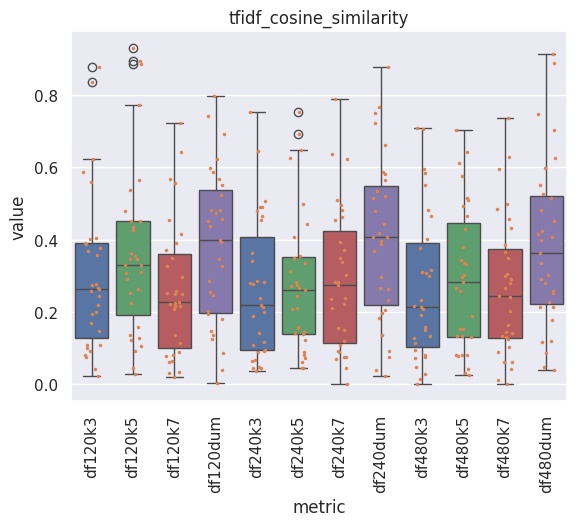

PASSAGE CONTINUATION


/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


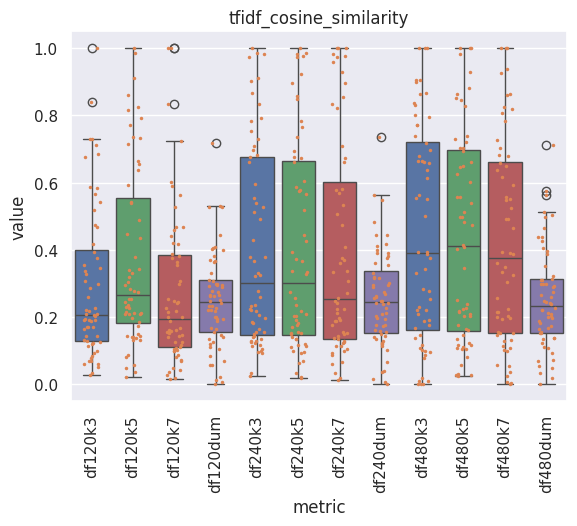

/tmp/ipykernel_262527/1464010781.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='metric', y='value', data=col_name, palette=palette)


MISLEADING QUESTIONS


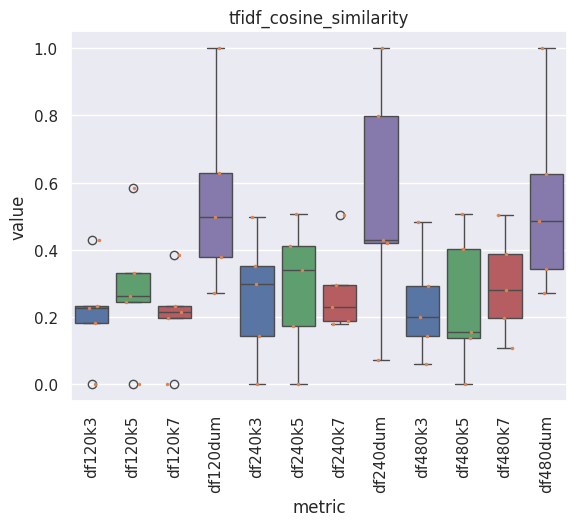

In [73]:
QA_stats = []
passage_stats = []
misleading_q_stats = []

for i in full_monty:
    passage_df = i[0:60]
    passage_df.name = i.name
    QA_df = i[60:91]
    QA_df.name = i.name
    misleading_q_df = i[91:]
    misleading_q_df.name = i.name
    passage_stats.append(passage_df)
    QA_stats.append(QA_df)
    misleading_q_stats.append(misleading_q_df)

for i in df120dum.columns[4:]:
    print("QUESTION & ANSWER")
    box_plot(QA_stats, i)
    print("PASSAGE CONTINUATION")
    box_plot(passage_stats, i)
    print("MISLEADING QUESTIONS")
    box_plot(misleading_q_stats, i)

PearsonRResult(statistic=0.1604396010171923, pvalue=0.3885852526891407)
SignificanceResult(statistic=0.18391617561502685, pvalue=0.3219770977654912)


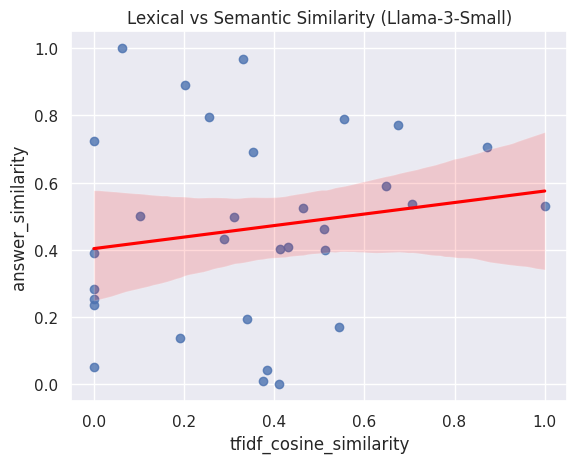

PearsonRResult(statistic=0.5616904572225788, pvalue=0.0010090570875055701)
SignificanceResult(statistic=0.5161290322580646, pvalue=0.0029567259704205064)


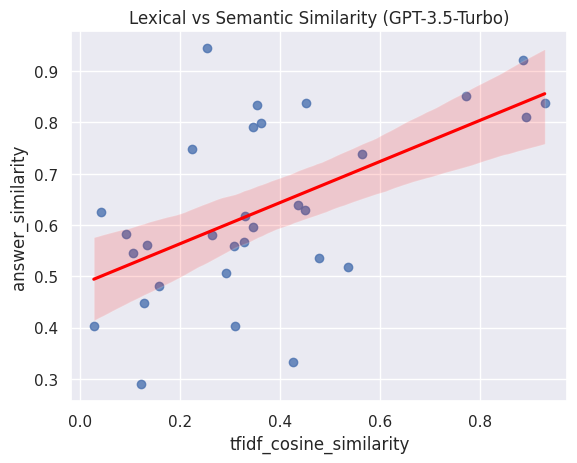

ACROSS ALL RAG PIPELINES
PearsonRResult(statistic=0.661391253884828, pvalue=5.098833534986371e-05)
SignificanceResult(statistic=0.6758064516129033, pvalue=3.017872657358296e-05)


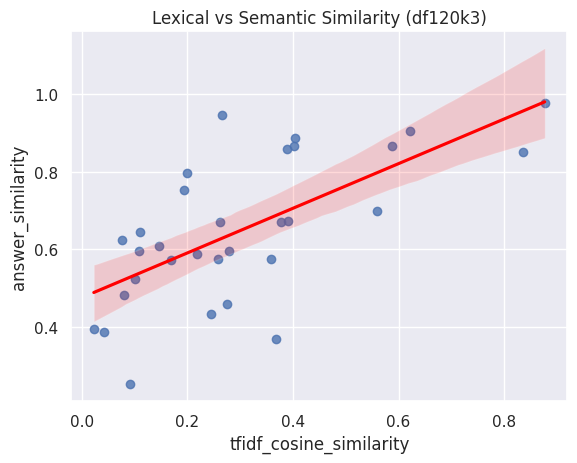

PearsonRResult(statistic=0.5616904572225788, pvalue=0.0010090570875055701)
SignificanceResult(statistic=0.5161290322580646, pvalue=0.0029567259704205064)


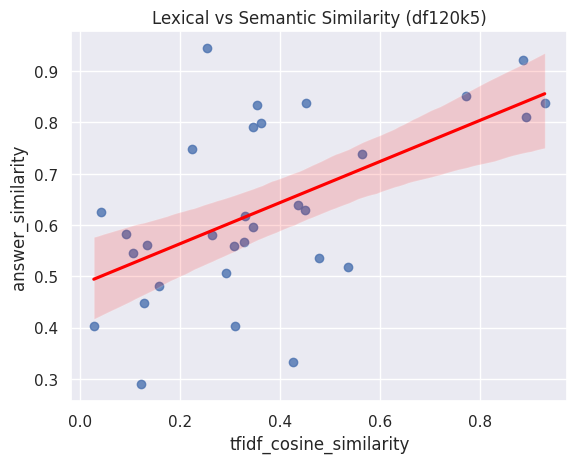

PearsonRResult(statistic=0.5870233610547899, pvalue=0.0005177474249831157)
SignificanceResult(statistic=0.5625, pvalue=0.0009885776702318481)


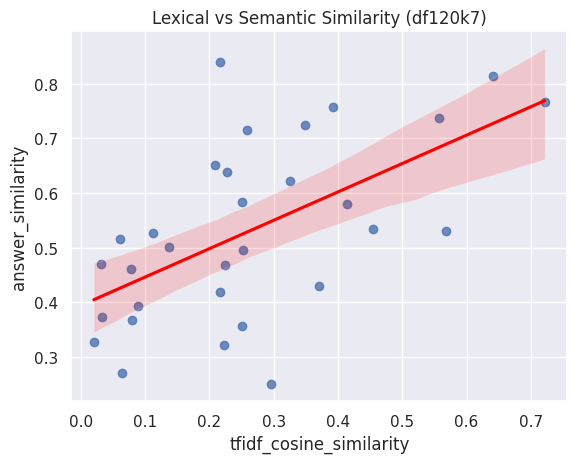

PearsonRResult(statistic=0.7315660981243266, pvalue=2.9294995167209695e-06)
SignificanceResult(statistic=0.7346774193548389, pvalue=2.5295107780101792e-06)


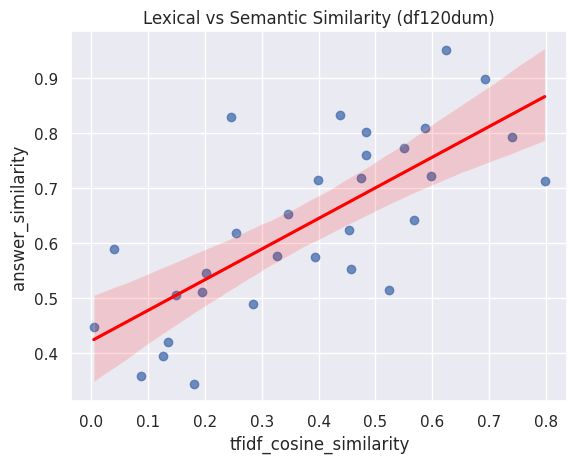

PearsonRResult(statistic=0.6276575467531862, pvalue=0.00015707939115521894)
SignificanceResult(statistic=0.6971774193548388, pvalue=1.3126325533015808e-05)


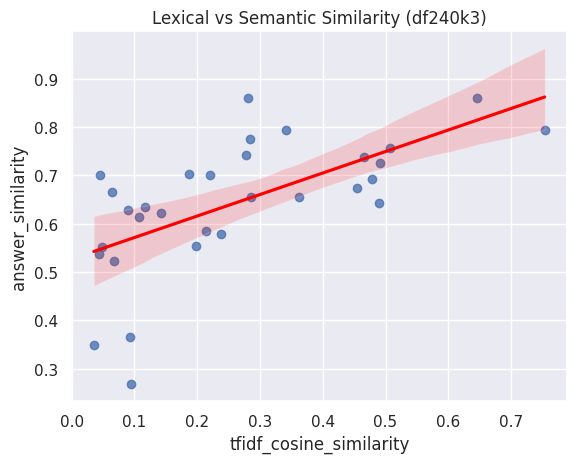

PearsonRResult(statistic=0.6486030839716465, pvalue=7.937124220181166e-05)
SignificanceResult(statistic=0.6362903225806452, pvalue=0.0001192802371147856)


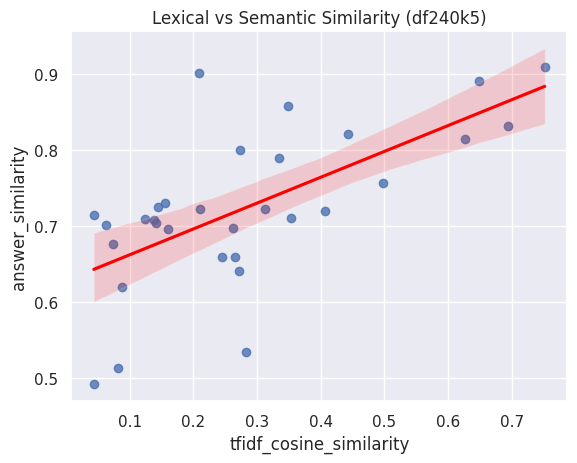

PearsonRResult(statistic=0.6304541707518595, pvalue=0.00014380765314173427)
SignificanceResult(statistic=0.6786290322580647, pvalue=2.7141863544367876e-05)


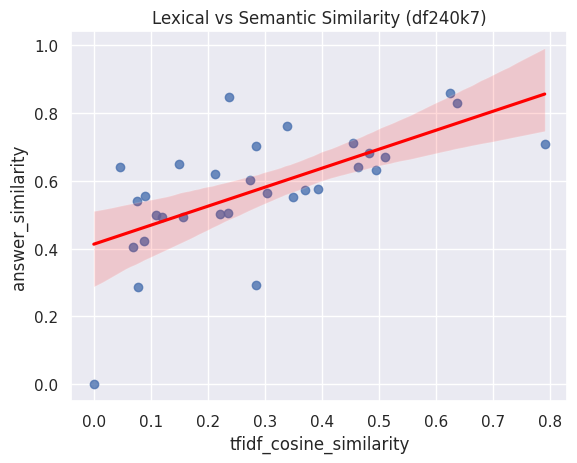

PearsonRResult(statistic=0.7221044830974229, pvalue=4.523466110341506e-06)
SignificanceResult(statistic=0.7129032258064517, pvalue=6.789174788259863e-06)


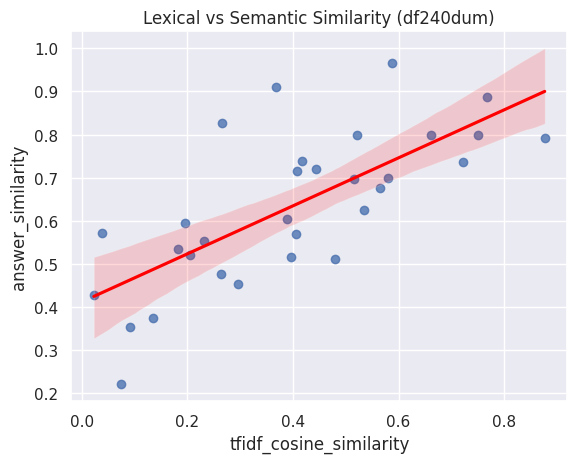

PearsonRResult(statistic=0.726460461695148, pvalue=3.7116035931916204e-06)
SignificanceResult(statistic=0.7806451612903227, pvalue=2.2180320220159952e-07)


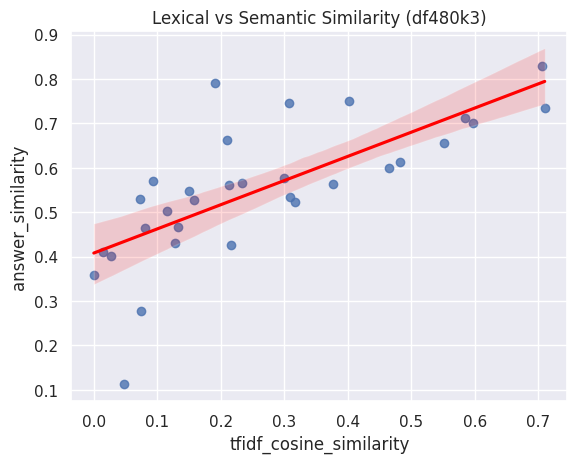

PearsonRResult(statistic=0.7484279353659662, pvalue=1.289521206833729e-06)
SignificanceResult(statistic=0.822983870967742, pvalue=1.3264543258875202e-08)


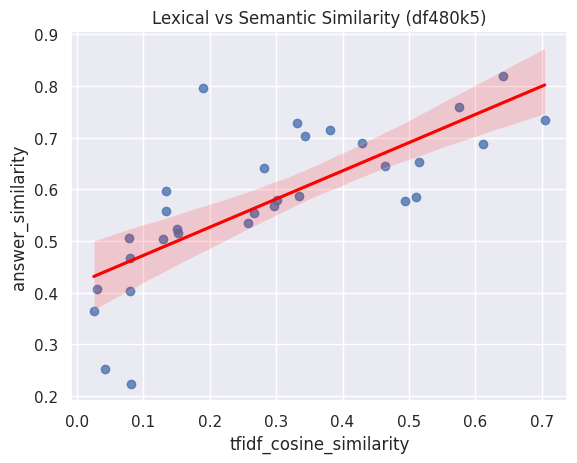

PearsonRResult(statistic=0.6062700589166546, pvalue=0.00030026788442939236)
SignificanceResult(statistic=0.6963709677419355, pvalue=1.3562596171927883e-05)


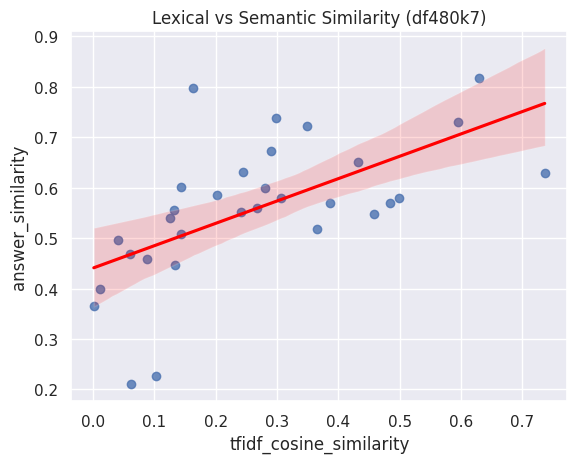

PearsonRResult(statistic=0.7028930299973086, pvalue=1.0379638487149458e-05)
SignificanceResult(statistic=0.7229838709677421, pvalue=4.347668072764423e-06)


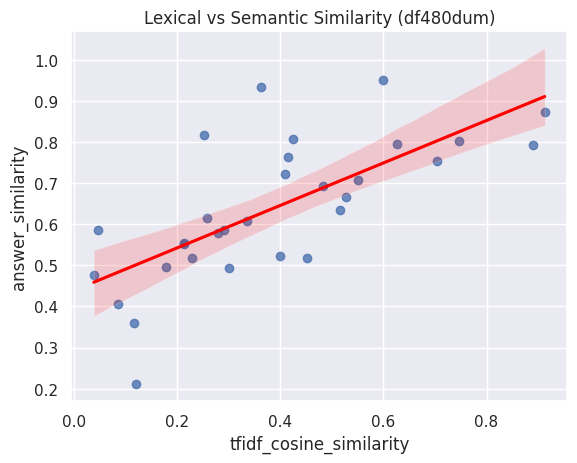

In [74]:
correlation_plot(ollamaQA, 'Llama-3-Small')
correlation_plot(QA_stats[1], 'GPT-3.5-Turbo')
print("ACROSS ALL RAG PIPELINES")
for i in QA_stats:
    correlation_plot(i)